In [1]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import bilby
import h5py
from scipy.integrate import quad
import astropy.units as u
from astropy.cosmology import z_at_value

The Luminosity distance for this model is

$$d_L^{\rm GW} = d_L\left[1+\left(\frac{d_L}{R_c} \right)^n \right] ^{\frac{D-2}{2n}}$$

Taken from https://arxiv.org/pdf/1811.00364.pdf, https://arxiv.org/abs/0709.0003, https://arxiv.org/abs/1801.08160 using the assumption that $R_c \ll d_l$. GR recovered for $D=4$

In [2]:
def gw_luminosity_distance(z,cosmology,D,Rc,n):
    dl_cosmo = cosmology.luminosity_distance(z).value
    return dl_cosmo*np.power((1+np.power(dl_cosmo/Rc,n)),(1/n)*(D-4)/2)

In [3]:
def selection_effect(d_max,z_guess,pdet,cosmology,D,Rc,n):
    
    funct_to_solve = lambda z: gw_luminosity_distance(z,cosmology,D,Rc,n)-d_max
    
    zcrit=0 
    while zcrit==0:
        zcrit=fsolve(funct_to_solve,z_guess, xtol=0.001)[0] # Initial solution of z_guess
    

    z_array=np.logspace(-6,np.log10(zcrit),1000)
    
    dl_gw = gw_luminosity_distance(z_array,cosmology,D,Rc,n)
    prior = cosmology.differential_comoving_volume(z_array).value/(1+z_array)

    return np.trapz(pdet(dl_gw)*prior,z_array)

In [4]:
class modGR_likelihood(bilby.Likelihood):

    def __init__(self,gkde_posterior,z_samples,pdet,d_max):

        super().__init__(parameters={})
        self.gkde_posterior=gkde_posterior
        self.pdet=pdet
        self.d_max=d_max
        self.z_samples=z_samples
        

    def log_likelihood(self):
        """ Returns the log likelihood
        """
                
        
        # Cosmo parameters
        H0 = self.parameters['H0']
        Om0 = self.parameters['Om0']
        
        # Deviation parameters
        D = self.parameters['D']
        Rc = self.parameters['Rc']
        n = self.parameters['n']
        
        cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)
        
        N_events = len(self.gkde_posterior)
        
        numerator=1
        sel_effect=1
        
        for i in range(N_events):
        
            dgws = gw_luminosity_distance(self.z_samples[i],cosmo,D,Rc,n)

            sel_effect *= selection_effect(self.d_max[i],np.mean(self.z_samples[i]),self.pdet[i],cosmo,D,Rc,n)
            
            evals=self.gkde_posterior[i](dgws)
            evals[evals<=1e-6]=1e-100
            
            if sel_effect==0: 
                print(self.parameters,i)
            numerator *= np.sum(evals*cosmo.differential_comoving_volume(
                self.z_samples[i]).value/((dgws**2)*(1+self.z_samples[i])))

        return np.log(numerator)-np.log(sel_effect)
        
        
        


##  analysis

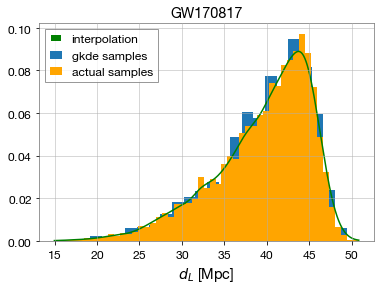

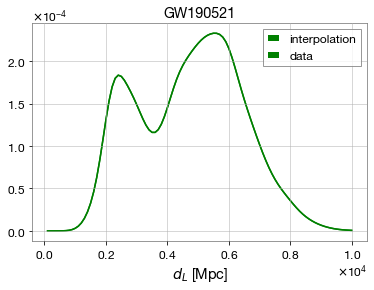

In [15]:
#provide here the list of events you want to analyse 
events = ['GW170817','GW190521']
mode = 'all'
wave = 'NRSur'
outdir = wave+'/EXTRA-dim_extended_prior_'+mode+'_GW170817_GW190521'

pos_inter_likeli = []
# Below load and fit with an interp1d the posterior of luminosity distance provided by LVC. 
# Note: please, do not remove the original d**2 prior. It is taken into account in the likelihood

for event in events:
    
    if event == 'GW170817':
        data = np.genfromtxt('high_spin_PhenomPNRT_posterior_samples.dat',names=True)
        lum_distance_samples = data['luminosity_distance_Mpc']
        plt.figure()
        
        gkde_pos = gaussian_kde(lum_distance_samples)
        dprox = np.linspace(np.min(lum_distance_samples),np.max(lum_distance_samples),1000)
        interp_pos = interp1d(dprox,gkde_pos(dprox),bounds_error=False,fill_value=0)

        pos_inter_likeli.append(interp_pos)

        _ = plt.hist(gkde_pos.resample(1000)[0],bins='auto',label='gkde samples',density=True)
        _ = plt.hist(lum_distance_samples,bins='auto',label='actual samples',color='orange',density=True)
        plt.plot(dprox,interp_pos(dprox),label='interpolation',color='green')
        plt.title(event)
        
    elif event == 'GW190521':
        plt.figure()
        data = np.genfromtxt('LOS_fit_'+wave+'_1e-3deg2.txt')
        interp_pos = interp1d(data[:,0],data[:,1],bounds_error=False,fill_value=0)
        pos_inter_likeli.append(interp_pos)
        plt.plot(data[:,0],interp_pos(data[:,0]),label='interpolation',color='green')
        plt.plot(data[:,0],data[:,1],label='data',color='green')
        plt.title(event)
        
    
    plt.legend()
    plt.xlabel(r'$d_L$ [Mpc]')

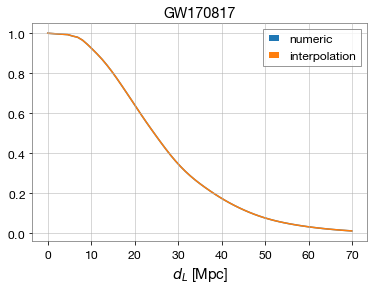

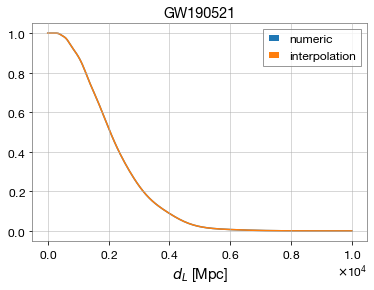

In [16]:
# Here it loads and and interpolate the precomputed detection probabilities

det_interp_likeli = []
d_max_likeli = []

for event in events:
    
    if event == 'GW170817':
        data = np.genfromtxt('det_prob_BNS.dat')
        d_max_likeli.append(200)
        data[:,0]*=0.35


    elif event == 'GW190521':
        data = np.genfromtxt('det_prob_BBH.dat')
        d_max_likeli.append(1e4)
                
    plt.figure()
    plt.title(event)

    plt.plot(data[:,0],data[:,1],label='numeric')
    interpolation_pdet = interp1d(data[:,0],data[:,1],bounds_error=False,fill_value=0)
    
    det_interp_likeli.append(interpolation_pdet)
    
    plt.plot(data[:,0],interpolation_pdet(data[:,0]),label='interpolation')
    plt.legend()
    plt.xlabel(r'$d_L$ [Mpc]')

In [17]:
z_em_likeli = []

for event in events:
    
    if event == 'GW170817':
        c=299792.458
        
        mu = np.array([3327/c, +310.0/c])
        sig = np.array([72/c,150/c])
        
        mu_tot= mu[0]-mu[1]
        sig_tot=np.sqrt(np.sum(sig**2))
        
        z_em_likeli.append(0.010033618884026258+0.0005445973324705001*np.random.randn(500))
        
    elif event == 'GW190521':
        z_em_likeli.append(0.438)

likeli = modGR_likelihood(pos_inter_likeli,z_em_likeli,det_interp_likeli,d_max_likeli)


priors = {}

priors = {}

if mode == 'planck':
    priors['H0']=bilby.core.prior.Gaussian(mu=67.66,sigma=0.42,name='H0',latex_label='$H_0$')
    priors['Om0']=bilby.core.prior.Gaussian(mu=0.3111,sigma=0.0056,name='Om0',latex_label='$\Omega_{m,0}$')
    
elif mode == 'all':
    priors['H0']=bilby.core.prior.Uniform(minimum=20,maximum=300,name='H0',latex_label='$H_0$')
    priors['Om0']=bilby.core.prior.Uniform(minimum=0.2,maximum=1.0,name='Om0',latex_label='$\Omega_{m,0}$')

priors['D']=bilby.core.prior.Uniform(minimum=3.5,maximum=7,name='D',latex_label='$D$')
priors['Rc']=bilby.core.prior.LogUniform(minimum=1e1,maximum=1e4,name='Rc',latex_label='$R_c$')
priors['n']=bilby.core.prior.LogUniform(minimum=1e-1,maximum=1e2,name='n',latex_label='$n$')

In [25]:
result=bilby.run_sampler(likelihood=likeli, priors=priors, outdir=outdir+'_prova', 
                         sampler='emcee',nwalkers=10,iterations=16000)

14:40 bilby INFO    : Running for label 'label', output will be saved to 'NRSur/EXTRA-dim_extended_prior_all_GW170817_GW190521_prova'
14:40 bilby INFO    : Search parameters:
14:40 bilby INFO    :   H0 = Uniform(minimum=20, maximum=300, name='H0', latex_label='$H_0$', unit=None, boundary=None)
14:40 bilby INFO    :   Om0 = Uniform(minimum=0.2, maximum=1.0, name='Om0', latex_label='$\\Omega_{m,0}$', unit=None, boundary=None)
14:40 bilby INFO    :   D = Uniform(minimum=3.5, maximum=7, name='D', latex_label='$D$', unit=None, boundary=None)
14:40 bilby INFO    :   Rc = LogUniform(minimum=10.0, maximum=10000.0, name='Rc', latex_label='$R_c$', unit=None, boundary=None)
14:40 bilby INFO    :   n = LogUniform(minimum=0.1, maximum=100.0, name='n', latex_label='$n$', unit=None, boundary=None)
14:40 bilby INFO    : Single likelihood evaluation took 5.201e-02 s
14:40 bilby WARNING : Supplied argument 'npool' not an argument of 'Emcee', removing.
14:40 bilby INFO    : Using sampler Emcee with kwarg

  1%|▏         | 105/8000 [00:36<38:03,  3.46it/s]


  1%|▏         | 106/8000 [00:37<34:11,  3.85it/s]


  1%|▏         | 107/8000 [00:37<37:53,  3.47it/s]


  1%|▏         | 108/8000 [00:37<38:15,  3.44it/s]


  1%|▏         | 109/8000 [00:38<40:29,  3.25it/s]


  1%|▏         | 110/8000 [00:38<35:59,  3.65it/s]


  1%|▏         | 111/8000 [00:38<36:47,  3.57it/s]


  1%|▏         | 112/8000 [00:38<33:17,  3.95it/s]


  1%|▏         | 113/8000 [00:39<36:46,  3.57it/s]


  1%|▏         | 114/8000 [00:39<35:32,  3.70it/s]


  1%|▏         | 115/8000 [00:39<32:49,  4.00it/s]


  1%|▏         | 116/8000 [00:39<32:26,  4.05it/s]


  1%|▏         | 117/8000 [00:39<28:21,  4.63it/s]


  1%|▏         | 118/8000 [00:40<35:35,  3.69it/s]


  1%|▏         | 119/8000 [00:40<37:06,  3.54it/s]


  2%|▏         | 120/8000 [00:41<39:10,  3.35it/s]


  2%|▏         | 121/8000 [00:41<41:16,  3.18it/s]


  2%|▏         | 122/8000 [00:41<42:46,  3.07it/s]


  2%|▏         | 123/8000 [00:41<39:31,  3.32i

  3%|▎         | 237/8000 [01:18<41:19,  3.13it/s]


  3%|▎         | 238/8000 [01:18<38:16,  3.38it/s]


  3%|▎         | 239/8000 [01:19<40:08,  3.22it/s]


  3%|▎         | 240/8000 [01:19<38:09,  3.39it/s]


  3%|▎         | 241/8000 [01:19<40:17,  3.21it/s]


  3%|▎         | 242/8000 [01:20<37:39,  3.43it/s]


  3%|▎         | 243/8000 [01:20<44:14,  2.92it/s]


  3%|▎         | 244/8000 [01:20<42:06,  3.07it/s]


  3%|▎         | 245/8000 [01:21<41:03,  3.15it/s]


  3%|▎         | 246/8000 [01:21<39:41,  3.26it/s]


  3%|▎         | 247/8000 [01:21<43:00,  3.00it/s]


  3%|▎         | 248/8000 [01:22<41:09,  3.14it/s]


  3%|▎         | 249/8000 [01:22<41:39,  3.10it/s]


  3%|▎         | 250/8000 [01:22<46:25,  2.78it/s]


  3%|▎         | 251/8000 [01:23<49:49,  2.59it/s]


  3%|▎         | 252/8000 [01:23<47:57,  2.69it/s]


  3%|▎         | 253/8000 [01:24<46:45,  2.76it/s]


  3%|▎         | 254/8000 [01:24<46:03,  2.80it/s]


  3%|▎         | 255/8000 [01:24<41:46,  3.09i

  5%|▍         | 369/8000 [02:00<38:05,  3.34it/s]


  5%|▍         | 370/8000 [02:00<35:49,  3.55it/s]


  5%|▍         | 371/8000 [02:00<34:02,  3.73it/s]


  5%|▍         | 372/8000 [02:01<32:58,  3.86it/s]


  5%|▍         | 373/8000 [02:01<30:23,  4.18it/s]


  5%|▍         | 374/8000 [02:01<30:37,  4.15it/s]


  5%|▍         | 375/8000 [02:01<34:34,  3.68it/s]


  5%|▍         | 376/8000 [02:01<29:45,  4.27it/s]


  5%|▍         | 377/8000 [02:02<26:46,  4.75it/s]


  5%|▍         | 378/8000 [02:02<29:43,  4.27it/s]


  5%|▍         | 379/8000 [02:02<34:12,  3.71it/s]


  5%|▍         | 380/8000 [02:03<35:26,  3.58it/s]


  5%|▍         | 381/8000 [02:03<40:15,  3.15it/s]


  5%|▍         | 382/8000 [02:03<35:40,  3.56it/s]


  5%|▍         | 383/8000 [02:03<36:14,  3.50it/s]


  5%|▍         | 384/8000 [02:04<38:34,  3.29it/s]


  5%|▍         | 385/8000 [02:04<32:27,  3.91it/s]


  5%|▍         | 386/8000 [02:04<35:57,  3.53it/s]


  5%|▍         | 387/8000 [02:04<30:20,  4.18i

  6%|▋         | 501/8000 [02:41<38:07,  3.28it/s]


  6%|▋         | 502/8000 [02:41<41:36,  3.00it/s]


  6%|▋         | 503/8000 [02:41<40:51,  3.06it/s]


  6%|▋         | 504/8000 [02:42<36:00,  3.47it/s]


  6%|▋         | 505/8000 [02:42<38:25,  3.25it/s]


  6%|▋         | 506/8000 [02:42<34:05,  3.66it/s]


  6%|▋         | 507/8000 [02:42<33:27,  3.73it/s]


  6%|▋         | 508/8000 [02:43<34:32,  3.62it/s]


  6%|▋         | 509/8000 [02:43<35:14,  3.54it/s]


  6%|▋         | 510/8000 [02:43<35:46,  3.49it/s]


  6%|▋         | 511/8000 [02:44<38:04,  3.28it/s]


  6%|▋         | 512/8000 [02:44<41:40,  2.99it/s]


  6%|▋         | 513/8000 [02:44<40:18,  3.10it/s]


  6%|▋         | 514/8000 [02:44<35:35,  3.51it/s]


  6%|▋         | 515/8000 [02:45<36:10,  3.45it/s]


  6%|▋         | 516/8000 [02:45<38:39,  3.23it/s]


  6%|▋         | 517/8000 [02:45<38:15,  3.26it/s]


  6%|▋         | 518/8000 [02:46<40:10,  3.10it/s]


  6%|▋         | 519/8000 [02:46<37:33,  3.32i

  8%|▊         | 634/8000 [03:23<34:22,  3.57it/s]


  8%|▊         | 635/8000 [03:23<39:46,  3.09it/s]


  8%|▊         | 636/8000 [03:24<41:50,  2.93it/s]


  8%|▊         | 637/8000 [03:24<42:08,  2.91it/s]


  8%|▊         | 638/8000 [03:24<40:17,  3.05it/s]


  8%|▊         | 639/8000 [03:25<38:53,  3.15it/s]


  8%|▊         | 640/8000 [03:25<39:36,  3.10it/s]


  8%|▊         | 641/8000 [03:25<38:25,  3.19it/s]


  8%|▊         | 642/8000 [03:25<33:48,  3.63it/s]


  8%|▊         | 643/8000 [03:26<39:32,  3.10it/s]


  8%|▊         | 644/8000 [03:26<38:21,  3.20it/s]


  8%|▊         | 645/8000 [03:26<35:45,  3.43it/s]


  8%|▊         | 646/8000 [03:27<39:27,  3.11it/s]


  8%|▊         | 647/8000 [03:27<40:37,  3.02it/s]


  8%|▊         | 648/8000 [03:27<38:49,  3.16it/s]


  8%|▊         | 649/8000 [03:28<43:18,  2.83it/s]


  8%|▊         | 650/8000 [03:28<44:13,  2.77it/s]


  8%|▊         | 651/8000 [03:29<43:21,  2.82it/s]


  8%|▊         | 652/8000 [03:29<44:47,  2.73i

 10%|▉         | 766/8000 [04:07<31:29,  3.83it/s]


 10%|▉         | 767/8000 [04:07<30:58,  3.89it/s]


 10%|▉         | 768/8000 [04:08<30:25,  3.96it/s]


 10%|▉         | 769/8000 [04:08<28:16,  4.26it/s]


 10%|▉         | 770/8000 [04:08<33:59,  3.54it/s]


 10%|▉         | 771/8000 [04:08<36:40,  3.29it/s]


 10%|▉         | 772/8000 [04:09<36:43,  3.28it/s]


 10%|▉         | 773/8000 [04:09<36:35,  3.29it/s]


 10%|▉         | 774/8000 [04:09<36:12,  3.33it/s]


 10%|▉         | 775/8000 [04:10<37:45,  3.19it/s]


 10%|▉         | 776/8000 [04:10<35:17,  3.41it/s]


 10%|▉         | 777/8000 [04:10<33:46,  3.56it/s]


 10%|▉         | 778/8000 [04:11<34:21,  3.50it/s]


 10%|▉         | 779/8000 [04:11<33:11,  3.63it/s]


 10%|▉         | 780/8000 [04:11<34:01,  3.54it/s]


 10%|▉         | 781/8000 [04:11<32:49,  3.67it/s]


 10%|▉         | 782/8000 [04:12<32:05,  3.75it/s]


 10%|▉         | 783/8000 [04:12<29:38,  4.06it/s]


 10%|▉         | 784/8000 [04:12<30:07,  3.99i

 11%|█         | 898/8000 [04:48<35:21,  3.35it/s]


 11%|█         | 899/8000 [04:49<40:51,  2.90it/s]


 11%|█▏        | 900/8000 [04:49<42:44,  2.77it/s]


 11%|█▏        | 901/8000 [04:49<39:13,  3.02it/s]


 11%|█▏        | 902/8000 [04:50<41:37,  2.84it/s]


 11%|█▏        | 903/8000 [04:50<39:52,  2.97it/s]


 11%|█▏        | 904/8000 [04:50<37:05,  3.19it/s]


 11%|█▏        | 905/8000 [04:51<42:02,  2.81it/s]


 11%|█▏        | 906/8000 [04:51<38:25,  3.08it/s]


 11%|█▏        | 907/8000 [04:51<39:21,  3.00it/s]


 11%|█▏        | 908/8000 [04:52<34:29,  3.43it/s]


 11%|█▏        | 909/8000 [04:52<44:26,  2.66it/s]


 11%|█▏        | 910/8000 [04:53<44:09,  2.68it/s]


 11%|█▏        | 911/8000 [04:53<48:57,  2.41it/s]


 11%|█▏        | 912/8000 [04:54<56:28,  2.09it/s]


 11%|█▏        | 913/8000 [04:54<51:34,  2.29it/s]


 11%|█▏        | 914/8000 [04:54<48:19,  2.44it/s]


 11%|█▏        | 915/8000 [04:55<42:22,  2.79it/s]


 11%|█▏        | 916/8000 [04:55<43:18,  2.73i

 13%|█▎        | 1029/8000 [05:31<34:22,  3.38it/s]


 13%|█▎        | 1030/8000 [05:32<37:56,  3.06it/s]


 13%|█▎        | 1031/8000 [05:32<34:45,  3.34it/s]


 13%|█▎        | 1032/8000 [05:32<37:56,  3.06it/s]


 13%|█▎        | 1033/8000 [05:32<36:32,  3.18it/s]


 13%|█▎        | 1034/8000 [05:33<39:29,  2.94it/s]


 13%|█▎        | 1035/8000 [05:33<37:45,  3.07it/s]


 13%|█▎        | 1036/8000 [05:33<36:24,  3.19it/s]


 13%|█▎        | 1037/8000 [05:34<33:52,  3.43it/s]


 13%|█▎        | 1038/8000 [05:34<35:19,  3.28it/s]


 13%|█▎        | 1039/8000 [05:34<38:44,  2.99it/s]


 13%|█▎        | 1040/8000 [05:35<33:23,  3.47it/s]


 13%|█▎        | 1041/8000 [05:35<39:08,  2.96it/s]


 13%|█▎        | 1042/8000 [05:35<39:00,  2.97it/s]


 13%|█▎        | 1043/8000 [05:36<37:07,  3.12it/s]


 13%|█▎        | 1044/8000 [05:36<37:56,  3.06it/s]


 13%|█▎        | 1045/8000 [05:36<34:56,  3.32it/s]


 13%|█▎        | 1046/8000 [05:37<36:31,  3.17it/s]


 13%|█▎        | 1047/8000 [

 14%|█▍        | 1159/8000 [06:14<36:35,  3.12it/s]


 14%|█▍        | 1160/8000 [06:14<37:27,  3.04it/s]


 15%|█▍        | 1161/8000 [06:14<40:22,  2.82it/s]


 15%|█▍        | 1162/8000 [06:15<36:35,  3.11it/s]


 15%|█▍        | 1163/8000 [06:15<37:14,  3.06it/s]


 15%|█▍        | 1164/8000 [06:15<38:04,  2.99it/s]


 15%|█▍        | 1165/8000 [06:16<40:48,  2.79it/s]


 15%|█▍        | 1166/8000 [06:16<44:51,  2.54it/s]


 15%|█▍        | 1167/8000 [06:17<41:07,  2.77it/s]


 15%|█▍        | 1168/8000 [06:17<38:22,  2.97it/s]


 15%|█▍        | 1169/8000 [06:17<38:23,  2.97it/s]


 15%|█▍        | 1170/8000 [06:17<35:18,  3.22it/s]


 15%|█▍        | 1171/8000 [06:18<36:39,  3.10it/s]


 15%|█▍        | 1172/8000 [06:18<35:51,  3.17it/s]


 15%|█▍        | 1173/8000 [06:18<35:32,  3.20it/s]


 15%|█▍        | 1174/8000 [06:19<32:55,  3.46it/s]


 15%|█▍        | 1175/8000 [06:19<34:30,  3.30it/s]


 15%|█▍        | 1176/8000 [06:19<30:37,  3.71it/s]


 15%|█▍        | 1177/8000 [

 16%|█▌        | 1289/8000 [06:58<30:30,  3.67it/s]


 16%|█▌        | 1290/8000 [06:58<31:12,  3.58it/s]


 16%|█▌        | 1291/8000 [06:58<30:03,  3.72it/s]


 16%|█▌        | 1292/8000 [06:59<33:17,  3.36it/s]


 16%|█▌        | 1293/8000 [06:59<36:48,  3.04it/s]


 16%|█▌        | 1294/8000 [06:59<37:12,  3.00it/s]


 16%|█▌        | 1295/8000 [07:00<34:05,  3.28it/s]


 16%|█▌        | 1296/8000 [07:00<30:18,  3.69it/s]


 16%|█▌        | 1297/8000 [07:00<32:58,  3.39it/s]


 16%|█▌        | 1298/8000 [07:00<36:55,  3.03it/s]


 16%|█▌        | 1299/8000 [07:01<35:23,  3.16it/s]


 16%|█▋        | 1300/8000 [07:01<31:18,  3.57it/s]


 16%|█▋        | 1301/8000 [07:01<29:53,  3.73it/s]


 16%|█▋        | 1302/8000 [07:01<29:01,  3.85it/s]


 16%|█▋        | 1303/8000 [07:02<30:28,  3.66it/s]


 16%|█▋        | 1304/8000 [07:02<30:07,  3.70it/s]


 16%|█▋        | 1305/8000 [07:02<27:42,  4.03it/s]


 16%|█▋        | 1306/8000 [07:03<31:13,  3.57it/s]


 16%|█▋        | 1307/8000 [

 18%|█▊        | 1419/8000 [07:42<34:15,  3.20it/s]


 18%|█▊        | 1420/8000 [07:42<34:09,  3.21it/s]


 18%|█▊        | 1421/8000 [07:42<30:44,  3.57it/s]


 18%|█▊        | 1422/8000 [07:42<31:33,  3.47it/s]


 18%|█▊        | 1423/8000 [07:43<32:18,  3.39it/s]


 18%|█▊        | 1424/8000 [07:43<36:02,  3.04it/s]


 18%|█▊        | 1425/8000 [07:44<38:54,  2.82it/s]


 18%|█▊        | 1426/8000 [07:44<39:31,  2.77it/s]


 18%|█▊        | 1427/8000 [07:44<41:14,  2.66it/s]


 18%|█▊        | 1428/8000 [07:45<38:53,  2.82it/s]


 18%|█▊        | 1429/8000 [07:45<37:26,  2.93it/s]


 18%|█▊        | 1430/8000 [07:45<41:21,  2.65it/s]


 18%|█▊        | 1431/8000 [07:46<38:59,  2.81it/s]


 18%|█▊        | 1432/8000 [07:46<33:55,  3.23it/s]


 18%|█▊        | 1433/8000 [07:47<44:35,  2.45it/s]


 18%|█▊        | 1434/8000 [07:47<37:29,  2.92it/s]


 18%|█▊        | 1435/8000 [07:47<39:10,  2.79it/s]


 18%|█▊        | 1436/8000 [07:47<38:37,  2.83it/s]


 18%|█▊        | 1437/8000 [

 19%|█▉        | 1549/8000 [08:25<40:42,  2.64it/s]


 19%|█▉        | 1550/8000 [08:25<40:12,  2.67it/s]


 19%|█▉        | 1551/8000 [08:26<41:57,  2.56it/s]


 19%|█▉        | 1552/8000 [08:26<38:46,  2.77it/s]


 19%|█▉        | 1553/8000 [08:26<33:15,  3.23it/s]


 19%|█▉        | 1554/8000 [08:26<31:07,  3.45it/s]


 19%|█▉        | 1555/8000 [08:27<32:58,  3.26it/s]


 19%|█▉        | 1556/8000 [08:27<32:50,  3.27it/s]


 19%|█▉        | 1557/8000 [08:28<37:03,  2.90it/s]


 19%|█▉        | 1558/8000 [08:28<34:19,  3.13it/s]


 19%|█▉        | 1559/8000 [08:28<36:40,  2.93it/s]


 20%|█▉        | 1560/8000 [08:29<37:09,  2.89it/s]


 20%|█▉        | 1561/8000 [08:29<35:56,  2.99it/s]


 20%|█▉        | 1562/8000 [08:29<34:46,  3.09it/s]


 20%|█▉        | 1563/8000 [08:29<32:52,  3.26it/s]


 20%|█▉        | 1564/8000 [08:30<34:47,  3.08it/s]


 20%|█▉        | 1565/8000 [08:30<40:27,  2.65it/s]


 20%|█▉        | 1566/8000 [08:31<39:32,  2.71it/s]


 20%|█▉        | 1567/8000 [

 21%|██        | 1680/8000 [09:09<32:15,  3.26it/s]


 21%|██        | 1681/8000 [09:09<33:54,  3.11it/s]


 21%|██        | 1682/8000 [09:09<38:25,  2.74it/s]


 21%|██        | 1683/8000 [09:10<36:24,  2.89it/s]


 21%|██        | 1684/8000 [09:10<41:47,  2.52it/s]


 21%|██        | 1685/8000 [09:11<38:40,  2.72it/s]


 21%|██        | 1686/8000 [09:11<37:55,  2.77it/s]


 21%|██        | 1687/8000 [09:11<34:40,  3.03it/s]


 21%|██        | 1688/8000 [09:11<30:23,  3.46it/s]


 21%|██        | 1689/8000 [09:12<27:20,  3.85it/s]


 21%|██        | 1690/8000 [09:12<27:03,  3.89it/s]


 21%|██        | 1691/8000 [09:12<29:57,  3.51it/s]


 21%|██        | 1692/8000 [09:13<35:46,  2.94it/s]


 21%|██        | 1693/8000 [09:13<37:32,  2.80it/s]


 21%|██        | 1694/8000 [09:13<38:57,  2.70it/s]


 21%|██        | 1695/8000 [09:14<41:36,  2.53it/s]


 21%|██        | 1696/8000 [09:14<38:26,  2.73it/s]


 21%|██        | 1697/8000 [09:15<38:06,  2.76it/s]


 21%|██        | 1698/8000 [

 23%|██▎       | 1810/8000 [09:52<32:10,  3.21it/s]


 23%|██▎       | 1811/8000 [09:52<32:17,  3.19it/s]


 23%|██▎       | 1812/8000 [09:52<32:17,  3.19it/s]


 23%|██▎       | 1813/8000 [09:53<35:23,  2.91it/s]


 23%|██▎       | 1814/8000 [09:53<35:48,  2.88it/s]


 23%|██▎       | 1815/8000 [09:53<34:44,  2.97it/s]


 23%|██▎       | 1816/8000 [09:54<35:27,  2.91it/s]


 23%|██▎       | 1817/8000 [09:54<29:35,  3.48it/s]


 23%|██▎       | 1818/8000 [09:54<31:59,  3.22it/s]


 23%|██▎       | 1819/8000 [09:54<33:25,  3.08it/s]


 23%|██▎       | 1820/8000 [09:55<37:52,  2.72it/s]


 23%|██▎       | 1821/8000 [09:55<36:30,  2.82it/s]


 23%|██▎       | 1822/8000 [09:56<37:03,  2.78it/s]


 23%|██▎       | 1823/8000 [09:56<32:22,  3.18it/s]


 23%|██▎       | 1824/8000 [09:56<37:31,  2.74it/s]


 23%|██▎       | 1825/8000 [09:57<37:44,  2.73it/s]


 23%|██▎       | 1826/8000 [09:57<36:09,  2.85it/s]


 23%|██▎       | 1827/8000 [09:58<42:41,  2.41it/s]


 23%|██▎       | 1828/8000 [

 24%|██▍       | 1940/8000 [10:38<32:26,  3.11it/s]


 24%|██▍       | 1941/8000 [10:38<33:42,  3.00it/s]


 24%|██▍       | 1942/8000 [10:39<36:16,  2.78it/s]


 24%|██▍       | 1943/8000 [10:39<37:35,  2.69it/s]


 24%|██▍       | 1944/8000 [10:39<38:10,  2.64it/s]


 24%|██▍       | 1945/8000 [10:40<35:37,  2.83it/s]


 24%|██▍       | 1946/8000 [10:40<35:24,  2.85it/s]


 24%|██▍       | 1947/8000 [10:40<33:40,  3.00it/s]


 24%|██▍       | 1948/8000 [10:41<35:45,  2.82it/s]


 24%|██▍       | 1949/8000 [10:41<39:53,  2.53it/s]


 24%|██▍       | 1950/8000 [10:42<36:54,  2.73it/s]


 24%|██▍       | 1951/8000 [10:42<31:32,  3.20it/s]


 24%|██▍       | 1952/8000 [10:42<28:01,  3.60it/s]


 24%|██▍       | 1953/8000 [10:42<34:13,  2.94it/s]


 24%|██▍       | 1954/8000 [10:43<32:34,  3.09it/s]


 24%|██▍       | 1955/8000 [10:43<34:27,  2.92it/s]


 24%|██▍       | 1956/8000 [10:43<34:21,  2.93it/s]


 24%|██▍       | 1957/8000 [10:44<31:29,  3.20it/s]


 24%|██▍       | 1958/8000 [

 26%|██▌       | 2070/8000 [11:23<39:02,  2.53it/s]


 26%|██▌       | 2071/8000 [11:23<41:34,  2.38it/s]


 26%|██▌       | 2072/8000 [11:24<36:45,  2.69it/s]


 26%|██▌       | 2073/8000 [11:24<34:52,  2.83it/s]


 26%|██▌       | 2074/8000 [11:24<32:04,  3.08it/s]


 26%|██▌       | 2075/8000 [11:25<33:06,  2.98it/s]


 26%|██▌       | 2076/8000 [11:25<36:01,  2.74it/s]


 26%|██▌       | 2077/8000 [11:25<34:34,  2.85it/s]


 26%|██▌       | 2078/8000 [11:26<36:21,  2.72it/s]


 26%|██▌       | 2079/8000 [11:26<36:44,  2.69it/s]


 26%|██▌       | 2080/8000 [11:26<34:23,  2.87it/s]


 26%|██▌       | 2081/8000 [11:27<33:11,  2.97it/s]


 26%|██▌       | 2082/8000 [11:27<39:53,  2.47it/s]


 26%|██▌       | 2083/8000 [11:28<36:24,  2.71it/s]


 26%|██▌       | 2084/8000 [11:28<35:27,  2.78it/s]


 26%|██▌       | 2085/8000 [11:28<33:34,  2.94it/s]


 26%|██▌       | 2086/8000 [11:28<33:32,  2.94it/s]


 26%|██▌       | 2087/8000 [11:29<32:17,  3.05it/s]


 26%|██▌       | 2088/8000 [

 28%|██▊       | 2201/8000 [12:09<32:57,  2.93it/s]


 28%|██▊       | 2202/8000 [12:10<35:23,  2.73it/s]


 28%|██▊       | 2203/8000 [12:10<33:55,  2.85it/s]


 28%|██▊       | 2204/8000 [12:11<32:48,  2.94it/s]


 28%|██▊       | 2205/8000 [12:11<30:32,  3.16it/s]


 28%|██▊       | 2206/8000 [12:11<29:00,  3.33it/s]


 28%|██▊       | 2207/8000 [12:11<29:20,  3.29it/s]


 28%|██▊       | 2208/8000 [12:12<29:23,  3.28it/s]


 28%|██▊       | 2209/8000 [12:12<31:07,  3.10it/s]


 28%|██▊       | 2210/8000 [12:12<27:39,  3.49it/s]


 28%|██▊       | 2211/8000 [12:13<29:56,  3.22it/s]


 28%|██▊       | 2212/8000 [12:13<28:35,  3.37it/s]


 28%|██▊       | 2213/8000 [12:13<33:48,  2.85it/s]


 28%|██▊       | 2214/8000 [12:14<34:45,  2.77it/s]


 28%|██▊       | 2215/8000 [12:14<32:39,  2.95it/s]


 28%|██▊       | 2216/8000 [12:14<32:44,  2.94it/s]


 28%|██▊       | 2217/8000 [12:15<34:22,  2.80it/s]


 28%|██▊       | 2218/8000 [12:15<34:10,  2.82it/s]


 28%|██▊       | 2219/8000 [

 29%|██▉       | 2332/8000 [12:56<31:18,  3.02it/s]


 29%|██▉       | 2333/8000 [12:57<32:24,  2.91it/s]


 29%|██▉       | 2334/8000 [12:57<31:10,  3.03it/s]


 29%|██▉       | 2335/8000 [12:57<29:15,  3.23it/s]


 29%|██▉       | 2336/8000 [12:57<30:37,  3.08it/s]


 29%|██▉       | 2337/8000 [12:58<30:04,  3.14it/s]


 29%|██▉       | 2338/8000 [12:58<31:11,  3.03it/s]


 29%|██▉       | 2339/8000 [12:58<30:33,  3.09it/s]


 29%|██▉       | 2340/8000 [12:59<30:02,  3.14it/s]


 29%|██▉       | 2341/8000 [12:59<31:11,  3.02it/s]


 29%|██▉       | 2342/8000 [12:59<30:44,  3.07it/s]


 29%|██▉       | 2343/8000 [13:00<33:25,  2.82it/s]


 29%|██▉       | 2344/8000 [13:00<33:52,  2.78it/s]


 29%|██▉       | 2345/8000 [13:01<34:12,  2.76it/s]


 29%|██▉       | 2346/8000 [13:01<34:18,  2.75it/s]


 29%|██▉       | 2347/8000 [13:01<33:22,  2.82it/s]


 29%|██▉       | 2348/8000 [13:02<34:11,  2.76it/s]


 29%|██▉       | 2349/8000 [13:02<32:54,  2.86it/s]


 29%|██▉       | 2350/8000 [

 31%|███       | 2462/8000 [13:43<32:27,  2.84it/s]


 31%|███       | 2463/8000 [13:43<30:02,  3.07it/s]


 31%|███       | 2464/8000 [13:44<29:43,  3.10it/s]


 31%|███       | 2465/8000 [13:44<30:44,  3.00it/s]


 31%|███       | 2466/8000 [13:44<28:29,  3.24it/s]


 31%|███       | 2467/8000 [13:44<24:26,  3.77it/s]


 31%|███       | 2468/8000 [13:45<25:34,  3.60it/s]


 31%|███       | 2469/8000 [13:45<28:09,  3.27it/s]


 31%|███       | 2470/8000 [13:45<25:19,  3.64it/s]


 31%|███       | 2471/8000 [13:46<25:07,  3.67it/s]


 31%|███       | 2472/8000 [13:46<28:54,  3.19it/s]


 31%|███       | 2473/8000 [13:46<30:13,  3.05it/s]


 31%|███       | 2474/8000 [13:47<32:29,  2.83it/s]


 31%|███       | 2475/8000 [13:47<31:21,  2.94it/s]


 31%|███       | 2476/8000 [13:48<33:20,  2.76it/s]


 31%|███       | 2477/8000 [13:48<30:30,  3.02it/s]


 31%|███       | 2478/8000 [13:48<35:31,  2.59it/s]


 31%|███       | 2479/8000 [13:49<33:43,  2.73it/s]


 31%|███       | 2480/8000 [

 32%|███▏      | 2593/8000 [14:28<29:25,  3.06it/s]


 32%|███▏      | 2594/8000 [14:29<28:45,  3.13it/s]


 32%|███▏      | 2595/8000 [14:29<31:05,  2.90it/s]


 32%|███▏      | 2596/8000 [14:30<34:21,  2.62it/s]


 32%|███▏      | 2597/8000 [14:30<37:09,  2.42it/s]


 32%|███▏      | 2598/8000 [14:30<36:17,  2.48it/s]


 32%|███▏      | 2599/8000 [14:31<34:15,  2.63it/s]


 32%|███▎      | 2600/8000 [14:31<31:34,  2.85it/s]


 33%|███▎      | 2601/8000 [14:31<28:03,  3.21it/s]


 33%|███▎      | 2602/8000 [14:32<28:23,  3.17it/s]


 33%|███▎      | 2603/8000 [14:32<29:44,  3.02it/s]


 33%|███▎      | 2604/8000 [14:32<30:46,  2.92it/s]


 33%|███▎      | 2605/8000 [14:33<27:06,  3.32it/s]


 33%|███▎      | 2606/8000 [14:33<25:03,  3.59it/s]


 33%|███▎      | 2607/8000 [14:33<27:27,  3.27it/s]


 33%|███▎      | 2608/8000 [14:33<29:21,  3.06it/s]


 33%|███▎      | 2609/8000 [14:34<29:12,  3.08it/s]


 33%|███▎      | 2610/8000 [14:34<30:31,  2.94it/s]


 33%|███▎      | 2611/8000 [

 34%|███▍      | 2723/8000 [15:12<27:02,  3.25it/s]


 34%|███▍      | 2724/8000 [15:12<31:32,  2.79it/s]


 34%|███▍      | 2725/8000 [15:13<32:37,  2.70it/s]


 34%|███▍      | 2726/8000 [15:13<30:35,  2.87it/s]


 34%|███▍      | 2727/8000 [15:13<27:54,  3.15it/s]


 34%|███▍      | 2728/8000 [15:14<25:58,  3.38it/s]


 34%|███▍      | 2729/8000 [15:14<27:17,  3.22it/s]


 34%|███▍      | 2730/8000 [15:14<26:56,  3.26it/s]


 34%|███▍      | 2731/8000 [15:15<24:02,  3.65it/s]


 34%|███▍      | 2732/8000 [15:15<24:46,  3.54it/s]


 34%|███▍      | 2733/8000 [15:15<24:06,  3.64it/s]


 34%|███▍      | 2734/8000 [15:15<26:17,  3.34it/s]


 34%|███▍      | 2735/8000 [15:16<26:36,  3.30it/s]


 34%|███▍      | 2736/8000 [15:16<29:20,  2.99it/s]


 34%|███▍      | 2737/8000 [15:16<28:37,  3.06it/s]


 34%|███▍      | 2738/8000 [15:17<24:05,  3.64it/s]


 34%|███▍      | 2739/8000 [15:17<26:13,  3.34it/s]


 34%|███▍      | 2740/8000 [15:17<26:29,  3.31it/s]


 34%|███▍      | 2741/8000 [

 36%|███▌      | 2853/8000 [15:55<28:45,  2.98it/s]


 36%|███▌      | 2854/8000 [15:55<25:27,  3.37it/s]


 36%|███▌      | 2855/8000 [15:55<26:08,  3.28it/s]


 36%|███▌      | 2856/8000 [15:55<23:46,  3.61it/s]


 36%|███▌      | 2857/8000 [15:55<20:47,  4.12it/s]


 36%|███▌      | 2858/8000 [15:56<25:34,  3.35it/s]


 36%|███▌      | 2859/8000 [15:56<26:10,  3.27it/s]


 36%|███▌      | 2860/8000 [15:56<23:39,  3.62it/s]


 36%|███▌      | 2861/8000 [15:57<30:36,  2.80it/s]


 36%|███▌      | 2862/8000 [15:57<24:51,  3.44it/s]


 36%|███▌      | 2863/8000 [15:58<28:40,  2.99it/s]


 36%|███▌      | 2864/8000 [15:58<26:14,  3.26it/s]


 36%|███▌      | 2865/8000 [15:58<24:46,  3.45it/s]


 36%|███▌      | 2866/8000 [15:58<27:25,  3.12it/s]


 36%|███▌      | 2867/8000 [15:59<28:06,  3.04it/s]


 36%|███▌      | 2868/8000 [15:59<27:27,  3.12it/s]


 36%|███▌      | 2869/8000 [16:00<31:19,  2.73it/s]


 36%|███▌      | 2870/8000 [16:00<28:33,  2.99it/s]


 36%|███▌      | 2871/8000 [

 37%|███▋      | 2984/8000 [16:37<30:58,  2.70it/s]


 37%|███▋      | 2985/8000 [16:38<34:59,  2.39it/s]


 37%|███▋      | 2986/8000 [16:38<35:12,  2.37it/s]


 37%|███▋      | 2987/8000 [16:39<31:13,  2.68it/s]


 37%|███▋      | 2988/8000 [16:39<28:33,  2.92it/s]


 37%|███▋      | 2989/8000 [16:39<29:08,  2.87it/s]


 37%|███▋      | 2990/8000 [16:40<30:48,  2.71it/s]


 37%|███▋      | 2991/8000 [16:40<29:40,  2.81it/s]


 37%|███▋      | 2992/8000 [16:40<31:04,  2.69it/s]


 37%|███▋      | 2993/8000 [16:41<29:49,  2.80it/s]


 37%|███▋      | 2994/8000 [16:41<27:31,  3.03it/s]


 37%|███▋      | 2995/8000 [16:41<28:22,  2.94it/s]


 37%|███▋      | 2996/8000 [16:42<27:42,  3.01it/s]


 37%|███▋      | 2997/8000 [16:42<30:45,  2.71it/s]


 37%|███▋      | 2998/8000 [16:42<27:39,  3.02it/s]


 37%|███▋      | 2999/8000 [16:43<25:31,  3.27it/s]


 38%|███▊      | 3000/8000 [16:43<24:01,  3.47it/s]


 38%|███▊      | 3001/8000 [16:43<24:16,  3.43it/s]


 38%|███▊      | 3002/8000 [

 39%|███▉      | 3114/8000 [17:22<28:47,  2.83it/s]


 39%|███▉      | 3115/8000 [17:22<29:16,  2.78it/s]


 39%|███▉      | 3116/8000 [17:23<29:37,  2.75it/s]


 39%|███▉      | 3117/8000 [17:23<32:25,  2.51it/s]


 39%|███▉      | 3118/8000 [17:24<35:02,  2.32it/s]


 39%|███▉      | 3119/8000 [17:24<32:12,  2.53it/s]


 39%|███▉      | 3120/8000 [17:24<31:18,  2.60it/s]


 39%|███▉      | 3121/8000 [17:24<28:04,  2.90it/s]


 39%|███▉      | 3122/8000 [17:25<26:09,  3.11it/s]


 39%|███▉      | 3123/8000 [17:25<23:22,  3.48it/s]


 39%|███▉      | 3124/8000 [17:25<25:08,  3.23it/s]


 39%|███▉      | 3125/8000 [17:26<25:12,  3.22it/s]


 39%|███▉      | 3126/8000 [17:26<24:38,  3.30it/s]


 39%|███▉      | 3127/8000 [17:26<26:20,  3.08it/s]


 39%|███▉      | 3128/8000 [17:26<22:41,  3.58it/s]


 39%|███▉      | 3129/8000 [17:27<26:15,  3.09it/s]


 39%|███▉      | 3130/8000 [17:27<28:58,  2.80it/s]


 39%|███▉      | 3131/8000 [17:28<36:14,  2.24it/s]


 39%|███▉      | 3132/8000 [

 41%|████      | 3244/8000 [18:06<28:20,  2.80it/s]


 41%|████      | 3245/8000 [18:07<25:06,  3.16it/s]


 41%|████      | 3246/8000 [18:07<23:52,  3.32it/s]


 41%|████      | 3247/8000 [18:07<24:03,  3.29it/s]


 41%|████      | 3248/8000 [18:08<24:12,  3.27it/s]


 41%|████      | 3249/8000 [18:08<25:39,  3.09it/s]


 41%|████      | 3250/8000 [18:08<25:17,  3.13it/s]


 41%|████      | 3251/8000 [18:09<25:23,  3.12it/s]


 41%|████      | 3252/8000 [18:09<27:35,  2.87it/s]


 41%|████      | 3253/8000 [18:09<25:30,  3.10it/s]


 41%|████      | 3254/8000 [18:10<26:34,  2.98it/s]


 41%|████      | 3255/8000 [18:10<28:36,  2.76it/s]


 41%|████      | 3256/8000 [18:10<29:57,  2.64it/s]


 41%|████      | 3257/8000 [18:11<28:25,  2.78it/s]


 41%|████      | 3258/8000 [18:11<23:38,  3.34it/s]


 41%|████      | 3259/8000 [18:11<20:17,  3.89it/s]


 41%|████      | 3260/8000 [18:11<24:00,  3.29it/s]


 41%|████      | 3261/8000 [18:12<29:25,  2.68it/s]


 41%|████      | 3262/8000 [

 42%|████▏     | 3374/8000 [18:50<30:13,  2.55it/s]


 42%|████▏     | 3375/8000 [18:50<27:26,  2.81it/s]


 42%|████▏     | 3376/8000 [18:51<27:39,  2.79it/s]


 42%|████▏     | 3377/8000 [18:51<26:31,  2.91it/s]


 42%|████▏     | 3378/8000 [18:51<23:20,  3.30it/s]


 42%|████▏     | 3379/8000 [18:52<24:36,  3.13it/s]


 42%|████▏     | 3380/8000 [18:52<25:46,  2.99it/s]


 42%|████▏     | 3381/8000 [18:52<26:57,  2.86it/s]


 42%|████▏     | 3382/8000 [18:53<25:13,  3.05it/s]


 42%|████▏     | 3383/8000 [18:53<26:37,  2.89it/s]


 42%|████▏     | 3384/8000 [18:53<27:19,  2.82it/s]


 42%|████▏     | 3385/8000 [18:54<25:13,  3.05it/s]


 42%|████▏     | 3386/8000 [18:54<27:40,  2.78it/s]


 42%|████▏     | 3387/8000 [18:54<26:59,  2.85it/s]


 42%|████▏     | 3388/8000 [18:55<27:49,  2.76it/s]


 42%|████▏     | 3389/8000 [18:55<29:28,  2.61it/s]


 42%|████▏     | 3390/8000 [18:56<30:32,  2.52it/s]


 42%|████▏     | 3391/8000 [18:56<29:59,  2.56it/s]


 42%|████▏     | 3392/8000 [

 44%|████▍     | 3504/8000 [19:36<28:19,  2.65it/s]


 44%|████▍     | 3505/8000 [19:37<30:40,  2.44it/s]


 44%|████▍     | 3506/8000 [19:37<30:15,  2.48it/s]


 44%|████▍     | 3507/8000 [19:38<28:29,  2.63it/s]


 44%|████▍     | 3508/8000 [19:38<27:19,  2.74it/s]


 44%|████▍     | 3509/8000 [19:38<29:50,  2.51it/s]


 44%|████▍     | 3510/8000 [19:39<28:14,  2.65it/s]


 44%|████▍     | 3511/8000 [19:39<28:13,  2.65it/s]


 44%|████▍     | 3512/8000 [19:39<28:17,  2.64it/s]


 44%|████▍     | 3513/8000 [19:40<29:33,  2.53it/s]


 44%|████▍     | 3514/8000 [19:40<30:23,  2.46it/s]


 44%|████▍     | 3515/8000 [19:41<30:59,  2.41it/s]


 44%|████▍     | 3516/8000 [19:41<31:24,  2.38it/s]


 44%|████▍     | 3517/8000 [19:42<31:37,  2.36it/s]


 44%|████▍     | 3518/8000 [19:42<30:29,  2.45it/s]


 44%|████▍     | 3519/8000 [19:42<28:26,  2.63it/s]


 44%|████▍     | 3520/8000 [19:43<34:04,  2.19it/s]


 44%|████▍     | 3521/8000 [19:43<34:01,  2.19it/s]


 44%|████▍     | 3522/8000 [

 45%|████▌     | 3634/8000 [20:25<26:27,  2.75it/s]


 45%|████▌     | 3635/8000 [20:25<27:40,  2.63it/s]


 45%|████▌     | 3636/8000 [20:26<23:36,  3.08it/s]


 45%|████▌     | 3637/8000 [20:26<23:01,  3.16it/s]


 45%|████▌     | 3638/8000 [20:26<23:41,  3.07it/s]


 45%|████▌     | 3639/8000 [20:27<22:01,  3.30it/s]


 46%|████▌     | 3640/8000 [20:27<23:10,  3.14it/s]


 46%|████▌     | 3641/8000 [20:27<24:19,  2.99it/s]


 46%|████▌     | 3642/8000 [20:27<21:26,  3.39it/s]


 46%|████▌     | 3643/8000 [20:28<20:45,  3.50it/s]


 46%|████▌     | 3644/8000 [20:28<23:25,  3.10it/s]


 46%|████▌     | 3645/8000 [20:28<19:40,  3.69it/s]


 46%|████▌     | 3646/8000 [20:29<22:47,  3.18it/s]


 46%|████▌     | 3647/8000 [20:29<23:55,  3.03it/s]


 46%|████▌     | 3648/8000 [20:29<26:04,  2.78it/s]


 46%|████▌     | 3649/8000 [20:30<23:53,  3.04it/s]


 46%|████▌     | 3650/8000 [20:30<25:06,  2.89it/s]


 46%|████▌     | 3651/8000 [20:31<28:00,  2.59it/s]


 46%|████▌     | 3652/8000 [

 47%|████▋     | 3764/8000 [21:11<22:00,  3.21it/s]


 47%|████▋     | 3765/8000 [21:11<19:34,  3.60it/s]


 47%|████▋     | 3766/8000 [21:11<20:04,  3.52it/s]


 47%|████▋     | 3767/8000 [21:12<21:42,  3.25it/s]


 47%|████▋     | 3768/8000 [21:12<21:32,  3.28it/s]


 47%|████▋     | 3769/8000 [21:12<23:41,  2.98it/s]


 47%|████▋     | 3770/8000 [21:13<27:35,  2.56it/s]


 47%|████▋     | 3771/8000 [21:13<27:49,  2.53it/s]


 47%|████▋     | 3772/8000 [21:14<27:52,  2.53it/s]


 47%|████▋     | 3773/8000 [21:14<24:46,  2.84it/s]


 47%|████▋     | 3774/8000 [21:14<21:32,  3.27it/s]


 47%|████▋     | 3775/8000 [21:15<22:48,  3.09it/s]


 47%|████▋     | 3776/8000 [21:15<23:34,  2.99it/s]


 47%|████▋     | 3777/8000 [21:15<22:00,  3.20it/s]


 47%|████▋     | 3778/8000 [21:16<24:24,  2.88it/s]


 47%|████▋     | 3779/8000 [21:16<25:02,  2.81it/s]


 47%|████▋     | 3780/8000 [21:16<23:24,  3.00it/s]


 47%|████▋     | 3781/8000 [21:16<22:00,  3.20it/s]


 47%|████▋     | 3782/8000 [

 49%|████▊     | 3895/8000 [21:54<20:11,  3.39it/s]


 49%|████▊     | 3896/8000 [21:55<19:42,  3.47it/s]


 49%|████▊     | 3897/8000 [21:55<21:31,  3.18it/s]


 49%|████▊     | 3898/8000 [21:55<23:02,  2.97it/s]


 49%|████▊     | 3899/8000 [21:56<23:53,  2.86it/s]


 49%|████▉     | 3900/8000 [21:56<23:10,  2.95it/s]


 49%|████▉     | 3901/8000 [21:56<23:38,  2.89it/s]


 49%|████▉     | 3902/8000 [21:57<27:38,  2.47it/s]


 49%|████▉     | 3903/8000 [21:57<26:38,  2.56it/s]


 49%|████▉     | 3904/8000 [21:58<26:57,  2.53it/s]


 49%|████▉     | 3905/8000 [21:58<25:40,  2.66it/s]


 49%|████▉     | 3906/8000 [21:58<24:06,  2.83it/s]


 49%|████▉     | 3907/8000 [21:59<24:07,  2.83it/s]


 49%|████▉     | 3908/8000 [21:59<21:02,  3.24it/s]


 49%|████▉     | 3909/8000 [21:59<19:08,  3.56it/s]


 49%|████▉     | 3910/8000 [22:00<20:27,  3.33it/s]


 49%|████▉     | 3911/8000 [22:00<21:44,  3.14it/s]


 49%|████▉     | 3912/8000 [22:00<27:05,  2.52it/s]


 49%|████▉     | 3913/8000 [

 50%|█████     | 4025/8000 [22:40<24:05,  2.75it/s]


 50%|█████     | 4026/8000 [22:40<23:44,  2.79it/s]


 50%|█████     | 4027/8000 [22:41<22:27,  2.95it/s]


 50%|█████     | 4028/8000 [22:41<21:37,  3.06it/s]


 50%|█████     | 4029/8000 [22:41<22:03,  3.00it/s]


 50%|█████     | 4030/8000 [22:42<19:23,  3.41it/s]


 50%|█████     | 4031/8000 [22:42<18:28,  3.58it/s]


 50%|█████     | 4032/8000 [22:42<21:01,  3.14it/s]


 50%|█████     | 4033/8000 [22:43<21:48,  3.03it/s]


 50%|█████     | 4034/8000 [22:43<21:25,  3.09it/s]


 50%|█████     | 4035/8000 [22:43<21:26,  3.08it/s]


 50%|█████     | 4036/8000 [22:44<23:03,  2.87it/s]


 50%|█████     | 4037/8000 [22:44<20:58,  3.15it/s]


 50%|█████     | 4038/8000 [22:44<22:35,  2.92it/s]


 50%|█████     | 4039/8000 [22:45<23:49,  2.77it/s]


 50%|█████     | 4040/8000 [22:45<20:32,  3.21it/s]


 51%|█████     | 4041/8000 [22:45<19:22,  3.41it/s]


 51%|█████     | 4042/8000 [22:45<16:27,  4.01it/s]


 51%|█████     | 4043/8000 [

 52%|█████▏    | 4155/8000 [23:24<24:24,  2.63it/s]


 52%|█████▏    | 4156/8000 [23:24<24:15,  2.64it/s]


 52%|█████▏    | 4157/8000 [23:25<27:11,  2.36it/s]


 52%|█████▏    | 4158/8000 [23:25<27:31,  2.33it/s]


 52%|█████▏    | 4159/8000 [23:26<27:30,  2.33it/s]


 52%|█████▏    | 4160/8000 [23:26<27:25,  2.33it/s]


 52%|█████▏    | 4161/8000 [23:26<24:27,  2.62it/s]


 52%|█████▏    | 4162/8000 [23:27<20:16,  3.15it/s]


 52%|█████▏    | 4163/8000 [23:27<24:20,  2.63it/s]


 52%|█████▏    | 4164/8000 [23:28<24:17,  2.63it/s]


 52%|█████▏    | 4165/8000 [23:28<23:10,  2.76it/s]


 52%|█████▏    | 4166/8000 [23:28<22:25,  2.85it/s]


 52%|█████▏    | 4167/8000 [23:28<20:53,  3.06it/s]


 52%|█████▏    | 4168/8000 [23:29<24:31,  2.60it/s]


 52%|█████▏    | 4169/8000 [23:29<23:20,  2.73it/s]


 52%|█████▏    | 4170/8000 [23:30<21:21,  2.99it/s]


 52%|█████▏    | 4171/8000 [23:30<20:59,  3.04it/s]


 52%|█████▏    | 4172/8000 [23:30<23:38,  2.70it/s]


 52%|█████▏    | 4173/8000 [

 54%|█████▎    | 4285/8000 [24:09<20:59,  2.95it/s]


 54%|█████▎    | 4286/8000 [24:09<20:26,  3.03it/s]


 54%|█████▎    | 4287/8000 [24:10<19:10,  3.23it/s]


 54%|█████▎    | 4288/8000 [24:10<20:10,  3.07it/s]


 54%|█████▎    | 4289/8000 [24:10<18:20,  3.37it/s]


 54%|█████▎    | 4290/8000 [24:11<17:52,  3.46it/s]


 54%|█████▎    | 4291/8000 [24:11<22:21,  2.77it/s]


 54%|█████▎    | 4292/8000 [24:11<20:47,  2.97it/s]


 54%|█████▎    | 4293/8000 [24:12<21:23,  2.89it/s]


 54%|█████▎    | 4294/8000 [24:12<20:50,  2.96it/s]


 54%|█████▎    | 4295/8000 [24:12<19:32,  3.16it/s]


 54%|█████▎    | 4296/8000 [24:13<18:41,  3.30it/s]


 54%|█████▎    | 4297/8000 [24:13<18:51,  3.27it/s]


 54%|█████▎    | 4298/8000 [24:13<18:24,  3.35it/s]


 54%|█████▎    | 4299/8000 [24:14<21:30,  2.87it/s]


 54%|█████▍    | 4300/8000 [24:14<21:54,  2.81it/s]


 54%|█████▍    | 4301/8000 [24:14<22:09,  2.78it/s]


 54%|█████▍    | 4302/8000 [24:15<19:34,  3.15it/s]


 54%|█████▍    | 4303/8000 [

 55%|█████▌    | 4415/8000 [24:54<17:45,  3.36it/s]


 55%|█████▌    | 4416/8000 [24:54<22:18,  2.68it/s]


 55%|█████▌    | 4417/8000 [24:55<21:18,  2.80it/s]


 55%|█████▌    | 4418/8000 [24:55<20:23,  2.93it/s]


 55%|█████▌    | 4419/8000 [24:55<19:52,  3.00it/s]


 55%|█████▌    | 4420/8000 [24:55<17:33,  3.40it/s]


 55%|█████▌    | 4421/8000 [24:56<19:42,  3.03it/s]


 55%|█████▌    | 4422/8000 [24:56<19:34,  3.05it/s]


 55%|█████▌    | 4423/8000 [24:56<18:37,  3.20it/s]


 55%|█████▌    | 4424/8000 [24:57<17:50,  3.34it/s]


 55%|█████▌    | 4425/8000 [24:57<17:16,  3.45it/s]


 55%|█████▌    | 4426/8000 [24:57<18:53,  3.15it/s]


 55%|█████▌    | 4427/8000 [24:58<18:17,  3.26it/s]


 55%|█████▌    | 4428/8000 [24:58<21:45,  2.74it/s]


 55%|█████▌    | 4429/8000 [24:59<23:38,  2.52it/s]


 55%|█████▌    | 4430/8000 [24:59<21:14,  2.80it/s]


 55%|█████▌    | 4431/8000 [24:59<19:33,  3.04it/s]


 55%|█████▌    | 4432/8000 [24:59<18:23,  3.23it/s]


 55%|█████▌    | 4433/8000 [

 57%|█████▋    | 4546/8000 [25:38<23:44,  2.42it/s]


 57%|█████▋    | 4547/8000 [25:38<21:59,  2.62it/s]


 57%|█████▋    | 4548/8000 [25:39<21:25,  2.68it/s]


 57%|█████▋    | 4549/8000 [25:39<22:03,  2.61it/s]


 57%|█████▋    | 4550/8000 [25:39<21:36,  2.66it/s]


 57%|█████▋    | 4551/8000 [25:40<17:43,  3.24it/s]


 57%|█████▋    | 4552/8000 [25:40<16:53,  3.40it/s]


 57%|█████▋    | 4553/8000 [25:40<16:20,  3.52it/s]


 57%|█████▋    | 4554/8000 [25:40<15:15,  3.76it/s]


 57%|█████▋    | 4555/8000 [25:41<16:29,  3.48it/s]


 57%|█████▋    | 4556/8000 [25:41<18:10,  3.16it/s]


 57%|█████▋    | 4557/8000 [25:42<20:27,  2.81it/s]


 57%|█████▋    | 4558/8000 [25:42<19:12,  2.99it/s]


 57%|█████▋    | 4559/8000 [25:42<19:11,  2.99it/s]


 57%|█████▋    | 4560/8000 [25:43<19:56,  2.88it/s]


 57%|█████▋    | 4561/8000 [25:43<19:37,  2.92it/s]


 57%|█████▋    | 4562/8000 [25:43<19:19,  2.97it/s]


 57%|█████▋    | 4563/8000 [25:44<21:49,  2.63it/s]


 57%|█████▋    | 4564/8000 [

 58%|█████▊    | 4676/8000 [26:26<16:04,  3.44it/s]


 58%|█████▊    | 4677/8000 [26:26<18:12,  3.04it/s]


 58%|█████▊    | 4678/8000 [26:26<17:56,  3.09it/s]


 58%|█████▊    | 4679/8000 [26:27<16:01,  3.45it/s]


 58%|█████▊    | 4680/8000 [26:27<17:12,  3.21it/s]


 59%|█████▊    | 4681/8000 [26:27<20:56,  2.64it/s]


 59%|█████▊    | 4682/8000 [26:28<18:12,  3.04it/s]


 59%|█████▊    | 4683/8000 [26:28<17:22,  3.18it/s]


 59%|█████▊    | 4684/8000 [26:28<21:13,  2.60it/s]


 59%|█████▊    | 4685/8000 [26:29<20:20,  2.72it/s]


 59%|█████▊    | 4686/8000 [26:29<21:16,  2.60it/s]


 59%|█████▊    | 4687/8000 [26:30<19:45,  2.79it/s]


 59%|█████▊    | 4688/8000 [26:30<17:50,  3.09it/s]


 59%|█████▊    | 4689/8000 [26:30<16:33,  3.33it/s]


 59%|█████▊    | 4690/8000 [26:30<14:51,  3.71it/s]


 59%|█████▊    | 4691/8000 [26:30<15:21,  3.59it/s]


 59%|█████▊    | 4692/8000 [26:31<17:33,  3.14it/s]


 59%|█████▊    | 4693/8000 [26:31<17:33,  3.14it/s]


 59%|█████▊    | 4694/8000 [

 60%|██████    | 4806/8000 [27:11<21:22,  2.49it/s]


 60%|██████    | 4807/8000 [27:12<20:04,  2.65it/s]


 60%|██████    | 4808/8000 [27:12<17:35,  3.02it/s]


 60%|██████    | 4809/8000 [27:12<18:55,  2.81it/s]


 60%|██████    | 4810/8000 [27:13<17:31,  3.03it/s]


 60%|██████    | 4811/8000 [27:13<18:55,  2.81it/s]


 60%|██████    | 4812/8000 [27:13<17:26,  3.05it/s]


 60%|██████    | 4813/8000 [27:14<18:01,  2.95it/s]


 60%|██████    | 4814/8000 [27:14<16:53,  3.14it/s]


 60%|██████    | 4815/8000 [27:14<16:49,  3.16it/s]


 60%|██████    | 4816/8000 [27:15<18:40,  2.84it/s]


 60%|██████    | 4817/8000 [27:15<19:59,  2.65it/s]


 60%|██████    | 4818/8000 [27:15<19:11,  2.76it/s]


 60%|██████    | 4819/8000 [27:16<20:18,  2.61it/s]


 60%|██████    | 4820/8000 [27:16<20:17,  2.61it/s]


 60%|██████    | 4821/8000 [27:16<17:41,  2.99it/s]


 60%|██████    | 4822/8000 [27:17<14:18,  3.70it/s]


 60%|██████    | 4823/8000 [27:17<13:29,  3.93it/s]


 60%|██████    | 4824/8000 [

 62%|██████▏   | 4936/8000 [27:57<17:24,  2.93it/s]


 62%|██████▏   | 4937/8000 [27:57<15:36,  3.27it/s]


 62%|██████▏   | 4938/8000 [27:58<16:30,  3.09it/s]


 62%|██████▏   | 4939/8000 [27:58<16:33,  3.08it/s]


 62%|██████▏   | 4940/8000 [27:59<18:14,  2.80it/s]


 62%|██████▏   | 4941/8000 [27:59<18:30,  2.76it/s]


 62%|██████▏   | 4942/8000 [27:59<18:40,  2.73it/s]


 62%|██████▏   | 4943/8000 [28:00<19:28,  2.62it/s]


 62%|██████▏   | 4944/8000 [28:00<20:53,  2.44it/s]


 62%|██████▏   | 4945/8000 [28:01<21:10,  2.40it/s]


 62%|██████▏   | 4946/8000 [28:01<19:42,  2.58it/s]


 62%|██████▏   | 4947/8000 [28:01<17:03,  2.98it/s]


 62%|██████▏   | 4949/8000 [28:02<15:44,  3.23it/s]


 62%|██████▏   | 4950/8000 [28:02<21:14,  2.39it/s]


 62%|██████▏   | 4951/8000 [28:03<20:00,  2.54it/s]


 62%|██████▏   | 4952/8000 [28:03<22:17,  2.28it/s]


 62%|██████▏   | 4953/8000 [28:04<20:16,  2.50it/s]


 62%|██████▏   | 4954/8000 [28:04<18:49,  2.70it/s]


 62%|██████▏   | 4955/8000 [

 63%|██████▎   | 5067/8000 [28:43<18:59,  2.57it/s]


 63%|██████▎   | 5068/8000 [28:44<18:43,  2.61it/s]


 63%|██████▎   | 5069/8000 [28:44<19:09,  2.55it/s]


 63%|██████▎   | 5070/8000 [28:44<18:44,  2.60it/s]


 63%|██████▎   | 5071/8000 [28:45<19:18,  2.53it/s]


 63%|██████▎   | 5072/8000 [28:45<20:28,  2.38it/s]


 63%|██████▎   | 5073/8000 [28:46<19:04,  2.56it/s]


 63%|██████▎   | 5074/8000 [28:46<18:51,  2.59it/s]


 63%|██████▎   | 5075/8000 [28:46<17:12,  2.83it/s]


 63%|██████▎   | 5076/8000 [28:47<17:35,  2.77it/s]


 63%|██████▎   | 5077/8000 [28:47<17:08,  2.84it/s]


 63%|██████▎   | 5078/8000 [28:47<17:31,  2.78it/s]


 63%|██████▎   | 5079/8000 [28:48<17:01,  2.86it/s]


 64%|██████▎   | 5080/8000 [28:48<18:19,  2.66it/s]


 64%|██████▎   | 5081/8000 [28:48<18:24,  2.64it/s]


 64%|██████▎   | 5082/8000 [28:49<20:43,  2.35it/s]


 64%|██████▎   | 5083/8000 [28:49<19:17,  2.52it/s]


 64%|██████▎   | 5084/8000 [28:50<17:33,  2.77it/s]


 64%|██████▎   | 5085/8000 [

 65%|██████▍   | 5197/8000 [29:28<15:49,  2.95it/s]


 65%|██████▍   | 5198/8000 [29:29<14:58,  3.12it/s]


 65%|██████▍   | 5199/8000 [29:29<15:47,  2.96it/s]


 65%|██████▌   | 5200/8000 [29:30<16:27,  2.83it/s]


 65%|██████▌   | 5201/8000 [29:30<16:54,  2.76it/s]


 65%|██████▌   | 5202/8000 [29:30<17:16,  2.70it/s]


 65%|██████▌   | 5203/8000 [29:31<18:14,  2.56it/s]


 65%|██████▌   | 5204/8000 [29:31<17:22,  2.68it/s]


 65%|██████▌   | 5205/8000 [29:31<16:47,  2.77it/s]


 65%|██████▌   | 5206/8000 [29:32<16:20,  2.85it/s]


 65%|██████▌   | 5207/8000 [29:32<14:34,  3.19it/s]


 65%|██████▌   | 5208/8000 [29:33<18:53,  2.46it/s]


 65%|██████▌   | 5209/8000 [29:33<19:37,  2.37it/s]


 65%|██████▌   | 5210/8000 [29:33<17:55,  2.59it/s]


 65%|██████▌   | 5211/8000 [29:34<18:20,  2.53it/s]


 65%|██████▌   | 5212/8000 [29:34<17:46,  2.61it/s]


 65%|██████▌   | 5213/8000 [29:34<14:31,  3.20it/s]


 65%|██████▌   | 5214/8000 [29:35<16:40,  2.78it/s]


 65%|██████▌   | 5215/8000 [

 67%|██████▋   | 5327/8000 [30:15<14:03,  3.17it/s]


 67%|██████▋   | 5328/8000 [30:16<14:57,  2.98it/s]


 67%|██████▋   | 5329/8000 [30:16<14:02,  3.17it/s]


 67%|██████▋   | 5330/8000 [30:16<13:54,  3.20it/s]


 67%|██████▋   | 5331/8000 [30:17<14:38,  3.04it/s]


 67%|██████▋   | 5332/8000 [30:17<13:47,  3.23it/s]


 67%|██████▋   | 5333/8000 [30:17<14:27,  3.07it/s]


 67%|██████▋   | 5334/8000 [30:18<14:18,  3.10it/s]


 67%|██████▋   | 5335/8000 [30:18<12:49,  3.46it/s]


 67%|██████▋   | 5336/8000 [30:18<14:37,  3.04it/s]


 67%|██████▋   | 5337/8000 [30:19<15:20,  2.89it/s]


 67%|██████▋   | 5338/8000 [30:19<15:49,  2.80it/s]


 67%|██████▋   | 5339/8000 [30:19<17:36,  2.52it/s]


 67%|██████▋   | 5340/8000 [30:20<17:21,  2.55it/s]


 67%|██████▋   | 5341/8000 [30:20<16:25,  2.70it/s]


 67%|██████▋   | 5342/8000 [30:21<17:47,  2.49it/s]


 67%|██████▋   | 5343/8000 [30:21<16:36,  2.67it/s]


 67%|██████▋   | 5344/8000 [30:21<16:30,  2.68it/s]


 67%|██████▋   | 5345/8000 [

 68%|██████▊   | 5457/8000 [31:02<17:15,  2.46it/s]


 68%|██████▊   | 5458/8000 [31:02<18:34,  2.28it/s]


 68%|██████▊   | 5459/8000 [31:02<16:18,  2.60it/s]


 68%|██████▊   | 5460/8000 [31:03<17:40,  2.40it/s]


 68%|██████▊   | 5461/8000 [31:03<16:59,  2.49it/s]


 68%|██████▊   | 5462/8000 [31:04<17:53,  2.37it/s]


 68%|██████▊   | 5463/8000 [31:04<16:48,  2.52it/s]


 68%|██████▊   | 5464/8000 [31:04<15:16,  2.77it/s]


 68%|██████▊   | 5465/8000 [31:05<16:12,  2.61it/s]


 68%|██████▊   | 5466/8000 [31:05<12:45,  3.31it/s]


 68%|██████▊   | 5467/8000 [31:05<12:51,  3.28it/s]


 68%|██████▊   | 5468/8000 [31:05<12:31,  3.37it/s]


 68%|██████▊   | 5469/8000 [31:06<13:39,  3.09it/s]


 68%|██████▊   | 5470/8000 [31:06<12:28,  3.38it/s]


 68%|██████▊   | 5471/8000 [31:06<12:14,  3.44it/s]


 68%|██████▊   | 5472/8000 [31:07<13:17,  3.17it/s]


 68%|██████▊   | 5473/8000 [31:07<13:25,  3.14it/s]


 68%|██████▊   | 5474/8000 [31:07<15:09,  2.78it/s]


 68%|██████▊   | 5475/8000 [

 70%|██████▉   | 5587/8000 [31:48<14:43,  2.73it/s]


 70%|██████▉   | 5588/8000 [31:48<14:43,  2.73it/s]


 70%|██████▉   | 5589/8000 [31:48<14:20,  2.80it/s]


 70%|██████▉   | 5590/8000 [31:49<13:56,  2.88it/s]


 70%|██████▉   | 5591/8000 [31:49<13:02,  3.08it/s]


 70%|██████▉   | 5592/8000 [31:49<15:03,  2.66it/s]


 70%|██████▉   | 5593/8000 [31:50<16:03,  2.50it/s]


 70%|██████▉   | 5594/8000 [31:50<14:13,  2.82it/s]


 70%|██████▉   | 5595/8000 [31:51<15:38,  2.56it/s]


 70%|██████▉   | 5596/8000 [31:51<13:45,  2.91it/s]


 70%|██████▉   | 5597/8000 [31:51<13:54,  2.88it/s]


 70%|██████▉   | 5598/8000 [31:51<12:46,  3.13it/s]


 70%|██████▉   | 5599/8000 [31:52<13:05,  3.06it/s]


 70%|███████   | 5600/8000 [31:52<13:54,  2.88it/s]


 70%|███████   | 5601/8000 [31:52<12:02,  3.32it/s]


 70%|███████   | 5602/8000 [31:53<13:08,  3.04it/s]


 70%|███████   | 5603/8000 [31:53<13:19,  3.00it/s]


 70%|███████   | 5604/8000 [31:54<14:44,  2.71it/s]


 70%|███████   | 5605/8000 [

 71%|███████▏  | 5717/8000 [32:33<14:19,  2.66it/s]


 71%|███████▏  | 5718/8000 [32:33<13:46,  2.76it/s]


 71%|███████▏  | 5719/8000 [32:34<13:58,  2.72it/s]


 72%|███████▏  | 5720/8000 [32:34<13:25,  2.83it/s]


 72%|███████▏  | 5721/8000 [32:34<13:01,  2.92it/s]


 72%|███████▏  | 5722/8000 [32:35<13:19,  2.85it/s]


 72%|███████▏  | 5723/8000 [32:35<13:35,  2.79it/s]


 72%|███████▏  | 5724/8000 [32:36<13:48,  2.75it/s]


 72%|███████▏  | 5725/8000 [32:36<13:55,  2.72it/s]


 72%|███████▏  | 5726/8000 [32:36<13:18,  2.85it/s]


 72%|███████▏  | 5727/8000 [32:36<12:31,  3.02it/s]


 72%|███████▏  | 5728/8000 [32:37<13:01,  2.91it/s]


 72%|███████▏  | 5729/8000 [32:37<12:07,  3.12it/s]


 72%|███████▏  | 5730/8000 [32:37<12:08,  3.11it/s]


 72%|███████▏  | 5731/8000 [32:38<12:08,  3.11it/s]


 72%|███████▏  | 5732/8000 [32:38<12:44,  2.97it/s]


 72%|███████▏  | 5733/8000 [32:39<13:10,  2.87it/s]


 72%|███████▏  | 5734/8000 [32:39<12:16,  3.08it/s]


 72%|███████▏  | 5735/8000 [

 73%|███████▎  | 5847/8000 [33:19<11:00,  3.26it/s]


 73%|███████▎  | 5848/8000 [33:19<10:30,  3.41it/s]


 73%|███████▎  | 5849/8000 [33:20<09:41,  3.70it/s]


 73%|███████▎  | 5850/8000 [33:20<09:48,  3.65it/s]


 73%|███████▎  | 5851/8000 [33:20<10:00,  3.58it/s]


 73%|███████▎  | 5852/8000 [33:21<10:09,  3.52it/s]


 73%|███████▎  | 5853/8000 [33:21<10:47,  3.31it/s]


 73%|███████▎  | 5854/8000 [33:21<12:54,  2.77it/s]


 73%|███████▎  | 5855/8000 [33:22<13:04,  2.73it/s]


 73%|███████▎  | 5856/8000 [33:22<12:03,  2.96it/s]


 73%|███████▎  | 5857/8000 [33:22<11:58,  2.98it/s]


 73%|███████▎  | 5858/8000 [33:23<13:04,  2.73it/s]


 73%|███████▎  | 5859/8000 [33:23<12:43,  2.80it/s]


 73%|███████▎  | 5860/8000 [33:24<13:08,  2.71it/s]


 73%|███████▎  | 5861/8000 [33:24<12:52,  2.77it/s]


 73%|███████▎  | 5862/8000 [33:24<13:41,  2.60it/s]


 73%|███████▎  | 5863/8000 [33:25<12:34,  2.83it/s]


 73%|███████▎  | 5864/8000 [33:25<11:09,  3.19it/s]


 73%|███████▎  | 5865/8000 [

 75%|███████▍  | 5977/8000 [34:07<11:41,  2.88it/s]


 75%|███████▍  | 5978/8000 [34:08<09:44,  3.46it/s]


 75%|███████▍  | 5979/8000 [34:08<11:53,  2.83it/s]


 75%|███████▍  | 5980/8000 [34:08<12:02,  2.80it/s]


 75%|███████▍  | 5981/8000 [34:09<11:33,  2.91it/s]


 75%|███████▍  | 5982/8000 [34:09<12:14,  2.75it/s]


 75%|███████▍  | 5983/8000 [34:09<11:34,  2.91it/s]


 75%|███████▍  | 5984/8000 [34:10<12:24,  2.71it/s]


 75%|███████▍  | 5985/8000 [34:10<13:30,  2.49it/s]


 75%|███████▍  | 5986/8000 [34:11<12:33,  2.67it/s]


 75%|███████▍  | 5987/8000 [34:11<13:10,  2.55it/s]


 75%|███████▍  | 5988/8000 [34:11<12:45,  2.63it/s]


 75%|███████▍  | 5989/8000 [34:12<11:54,  2.81it/s]


 75%|███████▍  | 5990/8000 [34:12<12:29,  2.68it/s]


 75%|███████▍  | 5991/8000 [34:12<11:33,  2.90it/s]


 75%|███████▍  | 5992/8000 [34:13<12:10,  2.75it/s]


 75%|███████▍  | 5993/8000 [34:13<11:37,  2.88it/s]


 75%|███████▍  | 5994/8000 [34:14<12:21,  2.71it/s]


 75%|███████▍  | 5995/8000 [

 76%|███████▋  | 6107/8000 [34:53<10:07,  3.12it/s]


 76%|███████▋  | 6109/8000 [34:53<08:29,  3.71it/s]


 76%|███████▋  | 6110/8000 [34:54<08:33,  3.68it/s]


 76%|███████▋  | 6111/8000 [34:54<08:35,  3.66it/s]


 76%|███████▋  | 6112/8000 [34:54<09:09,  3.44it/s]


 76%|███████▋  | 6113/8000 [34:54<09:05,  3.46it/s]


 76%|███████▋  | 6114/8000 [34:55<08:57,  3.51it/s]


 76%|███████▋  | 6115/8000 [34:55<11:12,  2.80it/s]


 76%|███████▋  | 6116/8000 [34:56<11:55,  2.63it/s]


 76%|███████▋  | 6117/8000 [34:56<11:22,  2.76it/s]


 76%|███████▋  | 6118/8000 [34:56<12:22,  2.53it/s]


 76%|███████▋  | 6119/8000 [34:57<11:14,  2.79it/s]


 76%|███████▋  | 6120/8000 [34:57<10:49,  2.90it/s]


 77%|███████▋  | 6121/8000 [34:57<10:58,  2.85it/s]


 77%|███████▋  | 6122/8000 [34:58<11:08,  2.81it/s]


 77%|███████▋  | 6123/8000 [34:58<12:23,  2.53it/s]


 77%|███████▋  | 6124/8000 [34:59<12:56,  2.41it/s]


 77%|███████▋  | 6125/8000 [34:59<13:41,  2.28it/s]


 77%|███████▋  | 6126/8000 [

 78%|███████▊  | 6239/8000 [35:39<11:40,  2.51it/s]


 78%|███████▊  | 6240/8000 [35:39<10:57,  2.68it/s]


 78%|███████▊  | 6241/8000 [35:39<09:06,  3.22it/s]


 78%|███████▊  | 6242/8000 [35:39<09:35,  3.05it/s]


 78%|███████▊  | 6243/8000 [35:40<09:02,  3.24it/s]


 78%|███████▊  | 6244/8000 [35:40<10:10,  2.88it/s]


 78%|███████▊  | 6245/8000 [35:41<11:00,  2.66it/s]


 78%|███████▊  | 6246/8000 [35:41<11:09,  2.62it/s]


 78%|███████▊  | 6247/8000 [35:41<10:43,  2.72it/s]


 78%|███████▊  | 6248/8000 [35:42<10:24,  2.80it/s]


 78%|███████▊  | 6249/8000 [35:42<10:37,  2.75it/s]


 78%|███████▊  | 6250/8000 [35:42<11:37,  2.51it/s]


 78%|███████▊  | 6251/8000 [35:43<11:28,  2.54it/s]


 78%|███████▊  | 6252/8000 [35:43<11:19,  2.57it/s]


 78%|███████▊  | 6253/8000 [35:44<11:15,  2.59it/s]


 78%|███████▊  | 6254/8000 [35:44<11:15,  2.58it/s]


 78%|███████▊  | 6255/8000 [35:44<11:35,  2.51it/s]


 78%|███████▊  | 6256/8000 [35:45<10:32,  2.76it/s]


 78%|███████▊  | 6257/8000 [

 80%|███████▉  | 6369/8000 [36:23<10:09,  2.68it/s]


 80%|███████▉  | 6370/8000 [36:24<09:58,  2.72it/s]


 80%|███████▉  | 6371/8000 [36:24<09:50,  2.76it/s]


 80%|███████▉  | 6372/8000 [36:24<09:21,  2.90it/s]


 80%|███████▉  | 6373/8000 [36:25<09:04,  2.99it/s]


 80%|███████▉  | 6374/8000 [36:25<09:23,  2.88it/s]


 80%|███████▉  | 6375/8000 [36:25<09:33,  2.83it/s]


 80%|███████▉  | 6376/8000 [36:26<09:36,  2.82it/s]


 80%|███████▉  | 6377/8000 [36:26<09:53,  2.74it/s]


 80%|███████▉  | 6378/8000 [36:27<10:42,  2.53it/s]


 80%|███████▉  | 6379/8000 [36:27<10:31,  2.57it/s]


 80%|███████▉  | 6380/8000 [36:27<10:47,  2.50it/s]


 80%|███████▉  | 6381/8000 [36:28<09:26,  2.86it/s]


 80%|███████▉  | 6382/8000 [36:28<09:28,  2.85it/s]


 80%|███████▉  | 6383/8000 [36:28<10:21,  2.60it/s]


 80%|███████▉  | 6384/8000 [36:29<10:45,  2.50it/s]


 80%|███████▉  | 6385/8000 [36:29<10:39,  2.53it/s]


 80%|███████▉  | 6386/8000 [36:29<09:40,  2.78it/s]


 80%|███████▉  | 6387/8000 [

 81%|████████  | 6499/8000 [37:11<08:15,  3.03it/s]


 81%|████████▏ | 6500/8000 [37:11<08:14,  3.03it/s]


 81%|████████▏ | 6501/8000 [37:12<07:47,  3.20it/s]


 81%|████████▏ | 6502/8000 [37:12<08:37,  2.89it/s]


 81%|████████▏ | 6503/8000 [37:12<08:36,  2.90it/s]


 81%|████████▏ | 6504/8000 [37:13<08:28,  2.94it/s]


 81%|████████▏ | 6505/8000 [37:13<09:06,  2.74it/s]


 81%|████████▏ | 6506/8000 [37:13<08:49,  2.82it/s]


 81%|████████▏ | 6507/8000 [37:14<07:49,  3.18it/s]


 81%|████████▏ | 6508/8000 [37:14<08:21,  2.97it/s]


 81%|████████▏ | 6509/8000 [37:14<08:23,  2.96it/s]


 81%|████████▏ | 6510/8000 [37:15<07:34,  3.28it/s]


 81%|████████▏ | 6511/8000 [37:15<08:14,  3.01it/s]


 81%|████████▏ | 6512/8000 [37:15<08:40,  2.86it/s]


 81%|████████▏ | 6513/8000 [37:16<08:56,  2.77it/s]


 81%|████████▏ | 6514/8000 [37:16<09:04,  2.73it/s]


 81%|████████▏ | 6515/8000 [37:16<08:47,  2.81it/s]


 81%|████████▏ | 6516/8000 [37:17<09:44,  2.54it/s]


 81%|████████▏ | 6517/8000 [

 83%|████████▎ | 6630/8000 [37:57<09:16,  2.46it/s]


 83%|████████▎ | 6631/8000 [37:57<08:51,  2.58it/s]


 83%|████████▎ | 6632/8000 [37:57<08:50,  2.58it/s]


 83%|████████▎ | 6633/8000 [37:58<08:30,  2.68it/s]


 83%|████████▎ | 6634/8000 [37:58<08:12,  2.77it/s]


 83%|████████▎ | 6635/8000 [37:58<08:01,  2.83it/s]


 83%|████████▎ | 6636/8000 [37:59<07:56,  2.86it/s]


 83%|████████▎ | 6637/8000 [37:59<07:27,  3.04it/s]


 83%|████████▎ | 6638/8000 [37:59<07:49,  2.90it/s]


 83%|████████▎ | 6639/8000 [38:00<06:57,  3.26it/s]


 83%|████████▎ | 6640/8000 [38:00<07:48,  2.91it/s]


 83%|████████▎ | 6641/8000 [38:00<07:41,  2.94it/s]


 83%|████████▎ | 6642/8000 [38:01<07:34,  2.99it/s]


 83%|████████▎ | 6643/8000 [38:01<08:12,  2.75it/s]


 83%|████████▎ | 6644/8000 [38:02<07:43,  2.92it/s]


 83%|████████▎ | 6645/8000 [38:02<08:18,  2.72it/s]


 83%|████████▎ | 6646/8000 [38:02<08:44,  2.58it/s]


 83%|████████▎ | 6647/8000 [38:03<09:10,  2.46it/s]


 83%|████████▎ | 6648/8000 [

 84%|████████▍ | 6760/8000 [38:42<07:01,  2.94it/s]


 85%|████████▍ | 6761/8000 [38:43<07:51,  2.63it/s]


 85%|████████▍ | 6762/8000 [38:43<07:20,  2.81it/s]


 85%|████████▍ | 6763/8000 [38:43<06:42,  3.07it/s]


 85%|████████▍ | 6764/8000 [38:43<06:54,  2.98it/s]


 85%|████████▍ | 6765/8000 [38:44<08:00,  2.57it/s]


 85%|████████▍ | 6766/8000 [38:44<07:50,  2.62it/s]


 85%|████████▍ | 6767/8000 [38:45<08:09,  2.52it/s]


 85%|████████▍ | 6768/8000 [38:45<08:46,  2.34it/s]


 85%|████████▍ | 6769/8000 [38:45<07:32,  2.72it/s]


 85%|████████▍ | 6770/8000 [38:46<07:37,  2.69it/s]


 85%|████████▍ | 6771/8000 [38:46<08:01,  2.55it/s]


 85%|████████▍ | 6772/8000 [38:47<07:18,  2.80it/s]


 85%|████████▍ | 6773/8000 [38:47<06:30,  3.14it/s]


 85%|████████▍ | 6774/8000 [38:47<05:55,  3.44it/s]


 85%|████████▍ | 6775/8000 [38:47<06:29,  3.14it/s]


 85%|████████▍ | 6776/8000 [38:48<07:18,  2.79it/s]


 85%|████████▍ | 6777/8000 [38:48<07:28,  2.73it/s]


 85%|████████▍ | 6778/8000 [

 86%|████████▌ | 6890/8000 [39:32<07:02,  2.63it/s]


 86%|████████▌ | 6891/8000 [39:32<06:56,  2.66it/s]


 86%|████████▌ | 6892/8000 [39:33<06:04,  3.04it/s]


 86%|████████▌ | 6893/8000 [39:33<05:43,  3.22it/s]


 86%|████████▌ | 6894/8000 [39:33<06:45,  2.73it/s]


 86%|████████▌ | 6895/8000 [39:34<06:12,  2.96it/s]


 86%|████████▌ | 6896/8000 [39:34<06:06,  3.01it/s]


 86%|████████▌ | 6897/8000 [39:34<06:20,  2.90it/s]


 86%|████████▌ | 6898/8000 [39:35<06:49,  2.69it/s]


 86%|████████▌ | 6899/8000 [39:35<07:27,  2.46it/s]


 86%|████████▋ | 6900/8000 [39:36<06:55,  2.65it/s]


 86%|████████▋ | 6901/8000 [39:36<06:43,  2.72it/s]


 86%|████████▋ | 6902/8000 [39:36<06:09,  2.98it/s]


 86%|████████▋ | 6903/8000 [39:37<06:39,  2.75it/s]


 86%|████████▋ | 6904/8000 [39:37<06:39,  2.74it/s]


 86%|████████▋ | 6905/8000 [39:37<06:24,  2.85it/s]


 86%|████████▋ | 6906/8000 [39:38<07:04,  2.58it/s]


 86%|████████▋ | 6907/8000 [39:38<07:14,  2.52it/s]


 86%|████████▋ | 6908/8000 [

 88%|████████▊ | 7020/8000 [40:21<05:59,  2.73it/s]


 88%|████████▊ | 7021/8000 [40:21<05:52,  2.78it/s]


 88%|████████▊ | 7022/8000 [40:22<05:56,  2.75it/s]


 88%|████████▊ | 7023/8000 [40:22<06:15,  2.60it/s]


 88%|████████▊ | 7024/8000 [40:22<05:53,  2.76it/s]


 88%|████████▊ | 7025/8000 [40:23<05:36,  2.89it/s]


 88%|████████▊ | 7026/8000 [40:23<05:57,  2.73it/s]


 88%|████████▊ | 7027/8000 [40:23<05:53,  2.75it/s]


 88%|████████▊ | 7028/8000 [40:24<05:21,  3.02it/s]


 88%|████████▊ | 7029/8000 [40:24<05:50,  2.77it/s]


 88%|████████▊ | 7030/8000 [40:25<06:20,  2.55it/s]


 88%|████████▊ | 7031/8000 [40:25<06:30,  2.48it/s]


 88%|████████▊ | 7032/8000 [40:25<06:57,  2.32it/s]


 88%|████████▊ | 7033/8000 [40:26<06:22,  2.53it/s]


 88%|████████▊ | 7034/8000 [40:26<06:10,  2.61it/s]


 88%|████████▊ | 7035/8000 [40:27<06:32,  2.46it/s]


 88%|████████▊ | 7036/8000 [40:27<06:35,  2.44it/s]


 88%|████████▊ | 7037/8000 [40:27<06:28,  2.48it/s]


 88%|████████▊ | 7038/8000 [

 89%|████████▉ | 7150/8000 [41:13<06:09,  2.30it/s]


 89%|████████▉ | 7151/8000 [41:13<05:56,  2.38it/s]


 89%|████████▉ | 7152/8000 [41:13<05:21,  2.64it/s]


 89%|████████▉ | 7153/8000 [41:14<05:23,  2.62it/s]


 89%|████████▉ | 7154/8000 [41:14<05:21,  2.63it/s]


 89%|████████▉ | 7155/8000 [41:14<04:53,  2.88it/s]


 89%|████████▉ | 7156/8000 [41:15<05:15,  2.68it/s]


 89%|████████▉ | 7157/8000 [41:15<05:18,  2.65it/s]


 89%|████████▉ | 7158/8000 [41:15<04:38,  3.02it/s]


 89%|████████▉ | 7159/8000 [41:16<05:17,  2.65it/s]


 90%|████████▉ | 7160/8000 [41:16<05:25,  2.58it/s]


 90%|████████▉ | 7161/8000 [41:17<05:47,  2.41it/s]


 90%|████████▉ | 7162/8000 [41:17<05:32,  2.52it/s]


 90%|████████▉ | 7163/8000 [41:17<05:30,  2.53it/s]


 90%|████████▉ | 7164/8000 [41:18<05:50,  2.38it/s]


 90%|████████▉ | 7165/8000 [41:18<05:54,  2.35it/s]


 90%|████████▉ | 7166/8000 [41:19<05:12,  2.66it/s]


 90%|████████▉ | 7167/8000 [41:19<05:20,  2.60it/s]


 90%|████████▉ | 7168/8000 [

 91%|█████████ | 7280/8000 [42:02<04:44,  2.53it/s]


 91%|█████████ | 7281/8000 [42:03<04:53,  2.45it/s]


 91%|█████████ | 7282/8000 [42:03<04:58,  2.41it/s]


 91%|█████████ | 7283/8000 [42:04<04:49,  2.47it/s]


 91%|█████████ | 7284/8000 [42:04<04:34,  2.61it/s]


 91%|█████████ | 7285/8000 [42:04<04:57,  2.41it/s]


 91%|█████████ | 7286/8000 [42:05<05:15,  2.27it/s]


 91%|█████████ | 7287/8000 [42:05<04:34,  2.59it/s]


 91%|█████████ | 7288/8000 [42:06<04:37,  2.57it/s]


 91%|█████████ | 7289/8000 [42:06<05:00,  2.36it/s]


 91%|█████████ | 7290/8000 [42:06<04:43,  2.51it/s]


 91%|█████████ | 7291/8000 [42:07<04:41,  2.52it/s]


 91%|█████████ | 7292/8000 [42:07<05:30,  2.14it/s]


 91%|█████████ | 7293/8000 [42:08<05:10,  2.28it/s]


 91%|█████████ | 7294/8000 [42:08<04:20,  2.71it/s]


 91%|█████████ | 7295/8000 [42:08<04:20,  2.70it/s]


 91%|█████████ | 7296/8000 [42:09<04:44,  2.48it/s]


 91%|█████████ | 7297/8000 [42:09<04:24,  2.66it/s]


 91%|█████████ | 7298/8000 [

 93%|█████████▎| 7411/8000 [42:52<04:00,  2.45it/s]


 93%|█████████▎| 7412/8000 [42:53<04:22,  2.24it/s]


 93%|█████████▎| 7413/8000 [42:53<04:25,  2.21it/s]


 93%|█████████▎| 7414/8000 [42:53<04:09,  2.35it/s]


 93%|█████████▎| 7415/8000 [42:54<03:50,  2.54it/s]


 93%|█████████▎| 7416/8000 [42:54<03:39,  2.66it/s]


 93%|█████████▎| 7417/8000 [42:54<03:38,  2.67it/s]


 93%|█████████▎| 7418/8000 [42:55<03:11,  3.03it/s]


 93%|█████████▎| 7419/8000 [42:55<03:13,  3.01it/s]


 93%|█████████▎| 7420/8000 [42:55<03:03,  3.16it/s]


 93%|█████████▎| 7421/8000 [42:56<03:06,  3.11it/s]


 93%|█████████▎| 7422/8000 [42:56<03:10,  3.04it/s]


 93%|█████████▎| 7423/8000 [42:56<03:28,  2.76it/s]


 93%|█████████▎| 7424/8000 [42:57<03:31,  2.72it/s]


 93%|█████████▎| 7425/8000 [42:57<03:14,  2.95it/s]


 93%|█████████▎| 7426/8000 [42:57<03:12,  2.97it/s]


 93%|█████████▎| 7427/8000 [42:58<03:28,  2.74it/s]


 93%|█████████▎| 7428/8000 [42:58<03:12,  2.97it/s]


 93%|█████████▎| 7429/8000 [

 94%|█████████▍| 7541/8000 [43:43<03:05,  2.47it/s]


 94%|█████████▍| 7542/8000 [43:43<03:02,  2.51it/s]


 94%|█████████▍| 7543/8000 [43:43<02:44,  2.78it/s]


 94%|█████████▍| 7544/8000 [43:44<02:56,  2.59it/s]


 94%|█████████▍| 7545/8000 [43:44<03:03,  2.47it/s]


 94%|█████████▍| 7546/8000 [43:45<03:22,  2.25it/s]


 94%|█████████▍| 7547/8000 [43:45<03:21,  2.24it/s]


 94%|█████████▍| 7548/8000 [43:46<03:07,  2.41it/s]


 94%|█████████▍| 7549/8000 [43:46<03:10,  2.37it/s]


 94%|█████████▍| 7550/8000 [43:46<03:05,  2.43it/s]


 94%|█████████▍| 7551/8000 [43:47<02:55,  2.55it/s]


 94%|█████████▍| 7552/8000 [43:47<03:08,  2.37it/s]


 94%|█████████▍| 7553/8000 [43:48<03:24,  2.19it/s]


 94%|█████████▍| 7554/8000 [43:48<03:27,  2.15it/s]


 94%|█████████▍| 7555/8000 [43:49<03:10,  2.34it/s]


 94%|█████████▍| 7556/8000 [43:49<02:56,  2.51it/s]


 94%|█████████▍| 7557/8000 [43:50<03:14,  2.28it/s]


 94%|█████████▍| 7558/8000 [43:50<03:06,  2.37it/s]


 94%|█████████▍| 7559/8000 [

 96%|█████████▌| 7671/8000 [44:33<02:11,  2.50it/s]


 96%|█████████▌| 7672/8000 [44:34<02:05,  2.62it/s]


 96%|█████████▌| 7673/8000 [44:34<02:11,  2.48it/s]


 96%|█████████▌| 7674/8000 [44:35<02:14,  2.42it/s]


 96%|█████████▌| 7675/8000 [44:35<02:01,  2.68it/s]


 96%|█████████▌| 7676/8000 [44:35<02:15,  2.39it/s]


 96%|█████████▌| 7677/8000 [44:36<02:03,  2.62it/s]


 96%|█████████▌| 7678/8000 [44:36<02:09,  2.49it/s]


 96%|█████████▌| 7679/8000 [44:37<02:27,  2.17it/s]


 96%|█████████▌| 7680/8000 [44:37<02:17,  2.33it/s]


 96%|█████████▌| 7681/8000 [44:37<02:13,  2.39it/s]


 96%|█████████▌| 7682/8000 [44:38<02:15,  2.34it/s]


 96%|█████████▌| 7683/8000 [44:38<02:12,  2.40it/s]


 96%|█████████▌| 7684/8000 [44:39<02:14,  2.34it/s]


 96%|█████████▌| 7685/8000 [44:39<01:55,  2.73it/s]


 96%|█████████▌| 7686/8000 [44:39<01:48,  2.90it/s]


 96%|█████████▌| 7687/8000 [44:40<01:53,  2.76it/s]


 96%|█████████▌| 7688/8000 [44:40<01:49,  2.84it/s]


 96%|█████████▌| 7689/8000 [

 98%|█████████▊| 7801/8000 [45:24<01:17,  2.58it/s]


 98%|█████████▊| 7802/8000 [45:25<01:16,  2.60it/s]


 98%|█████████▊| 7803/8000 [45:25<01:15,  2.60it/s]


 98%|█████████▊| 7804/8000 [45:25<01:10,  2.78it/s]


 98%|█████████▊| 7805/8000 [45:26<01:18,  2.49it/s]


 98%|█████████▊| 7806/8000 [45:26<01:22,  2.35it/s]


 98%|█████████▊| 7807/8000 [45:27<01:28,  2.17it/s]


 98%|█████████▊| 7808/8000 [45:27<01:25,  2.26it/s]


 98%|█████████▊| 7809/8000 [45:27<01:09,  2.75it/s]


 98%|█████████▊| 7810/8000 [45:28<01:07,  2.80it/s]


 98%|█████████▊| 7811/8000 [45:28<01:12,  2.60it/s]


 98%|█████████▊| 7812/8000 [45:28<01:03,  2.95it/s]


 98%|█████████▊| 7813/8000 [45:29<01:09,  2.69it/s]


 98%|█████████▊| 7814/8000 [45:29<01:13,  2.53it/s]


 98%|█████████▊| 7815/8000 [45:30<01:29,  2.08it/s]


 98%|█████████▊| 7816/8000 [45:30<01:22,  2.23it/s]


 98%|█████████▊| 7817/8000 [45:31<01:25,  2.14it/s]


 98%|█████████▊| 7818/8000 [45:31<01:16,  2.38it/s]


 98%|█████████▊| 7819/8000 [

 99%|█████████▉| 7931/8000 [46:14<00:30,  2.29it/s]


 99%|█████████▉| 7932/8000 [46:14<00:26,  2.54it/s]


 99%|█████████▉| 7933/8000 [46:15<00:29,  2.25it/s]


 99%|█████████▉| 7934/8000 [46:15<00:28,  2.28it/s]


 99%|█████████▉| 7935/8000 [46:16<00:27,  2.38it/s]


 99%|█████████▉| 7936/8000 [46:16<00:28,  2.27it/s]


 99%|█████████▉| 7937/8000 [46:16<00:21,  2.93it/s]


 99%|█████████▉| 7938/8000 [46:17<00:20,  2.99it/s]


 99%|█████████▉| 7939/8000 [46:17<00:19,  3.12it/s]


 99%|█████████▉| 7940/8000 [46:17<00:18,  3.16it/s]


 99%|█████████▉| 7941/8000 [46:18<00:18,  3.16it/s]


 99%|█████████▉| 7942/8000 [46:18<00:20,  2.80it/s]


 99%|█████████▉| 7943/8000 [46:18<00:19,  2.88it/s]


 99%|█████████▉| 7944/8000 [46:19<00:22,  2.49it/s]


 99%|█████████▉| 7945/8000 [46:19<00:21,  2.52it/s]


 99%|█████████▉| 7946/8000 [46:20<00:21,  2.48it/s]


 99%|█████████▉| 7947/8000 [46:20<00:19,  2.78it/s]


 99%|█████████▉| 7948/8000 [46:20<00:18,  2.74it/s]


 99%|█████████▉| 7949/8000 [

In [27]:
result.plot_corner()

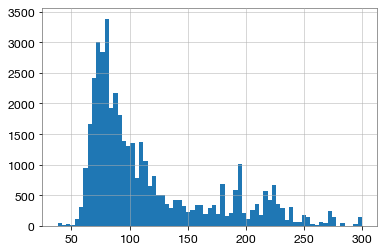

In [34]:
ii=np.where(result.posterior['Rc']<=500)[0]
_=plt.hist(result.posterior['H0'][ii],bins='auto')